<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230725_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [4]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [7]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [8]:
main_figsize=(15,3)

In [9]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [10]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [11]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []

    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)

    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))

    print("Test f1 score: {}".format(f1))

    test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1,test_analysis_df

In [12]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [13]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model
        self.lambda_model = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x,y, v):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss, self.lambda_model(v) #ret.sum().reshape(-1,))

In [14]:
a = torch.tensor([[1.,2.,3.,4.,5.]])
b = torch.tensor([[6.,7.,8.,9.,10.]])

torch.std(torch.cat((a,b), 0),0).mean()
#torch.std(torch.cat((a,b), 0),0).mean()

tensor(3.5355)

In [15]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)

    t_ones = torch.ones(b_dim).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            #print(ml.shape)
            #print(ml)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
            #print(a_loss.shape)
            #print(a_loss)

        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))  #+ torch.log(mine_loss.mean()+1)*0.001
        #print(g_loss.shape)
        #print(g_loss)
        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        if lambda_f >= 0.0:
            loss =  g_loss + a_loss + torch.std(torch.tensor((g_loss,a_loss))) +torch.std(torch.cat((ml,g_loss*t_ones), 0),0).mean()  #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
            #mg = ml + g_loss
            #loss = torch.mean(mg) + torch.std(ml) #+ torch.std(torch.cat((ml,g_loss), 0),0).mean()
        else:
            loss = g_loss.mean()

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.mean().cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,test_analysis = test_model(generator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,test_analysis,generator,adapter,df_loss

In [16]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [17]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [18]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({test_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({test_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [19]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [20]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0] # [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    #lambda_f_set = [-0.1,0.0,0.5,0.9] #[-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]

    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,test_analysis,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        for clm in test_analysis.columns:
            if clm not in result_table2:
                result_table2[clm] = []
            result_table2[clm].append(test_analysis[clm].values[0])


    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    a1_columns = []
    b1_columns = []
    c1_columns = []
    a2_columns = []
    b2_columns = []
    c2_columns = []

    XS = X_train['b'].values
    for bk in np.unique(XS,axis = 0):
        a1_columns.append(f'Sum(MI{bk}.0)')
        b1_columns.append(f'Std(MI{bk}.0)')
        c1_columns.append(f'Ent(MI{bk}.0)')

        a2_columns.append(f'Sum(DR{bk}.0)')
        b2_columns.append(f'Std(DR{bk}.0)')
        c2_columns.append(f'Ent(DR{bk}.0)')

    for analysis_columns in [a1_columns,b1_columns,c1_columns,a2_columns,b2_columns,c2_columns]:
        print(analysis_columns)
        stds = np.std(result4_df[1:][analysis_columns],axis=1)

        print(stds)
        best_lambda = np.argmax(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
        print('max_lambda=',best_lambda)
        result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        best_lambda = np.argmin(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
        print('min_lambda=',best_lambda)
        result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    for analysis_columns in ['Test Sum(MI)','Test Std(MI)','Test Ent(MI)','Test Sum(DR)','Test Std(DR)','Test Ent(DR)','TrainSum(MI)','TrainStd(MI)','TrainEnt(MI)']:
        best_lambda = result4_df[result4_df[analysis_columns]== np.max(result4_df[1:][analysis_columns])]['lambda']
        print(analysis_columns,'max_lambda=',best_lambda.values[0])
        result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        best_lambda = result4_df[result4_df[analysis_columns]== np.min(result4_df[1:][analysis_columns])]['lambda']
        print(analysis_columns,'min_lambda=',best_lambda.values[0])
        result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()
    '''
    '''
    best_lambda = result4_df[result4_df['TrainStd(MI)']== np.min(result4_df[1:]['TrainStd(MI)'])]['lambda']
    print('TrainStd(MI)','min_lambda=',best_lambda.values[0])
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    print(result4_df[1:]['Test Sum(MI)'])
    best_lambda = result4_df[result4_df['Test Sum(MI)']== np.max(result4_df[1:]['Test Sum(MI)'])]['lambda']
    print('Test Sum(MI)','max_lambda=',best_lambda.values[0])
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    best_lambda = result4_df[result4_df['Test Ent(MI)']== np.min(result4_df[1:]['Test Ent(MI)'])]['lambda']
    print('Test Ent(MI)','min_lambda=',best_lambda.values[0])
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    return result4_df

# 이론

+ 사실 입력 $x_i$ 에서 어떤 feature가 시간에 따라 importance가 변하는지 알기 어렵다. trainset의 경우, bucket size가 크지 않을 수 있으며, 또한 I(z,b)가 분명하게 나타나지 않을 수도 있기 때문이다.
+ 따라서 아래와 같은 구조를 제안한다.
+ 실험3~4는 sensitive featrue z에 대해, G(z,b)으로 전처리 하였으나, 이번 구조는 모든 feature에 대하여 $G(x_i,b)$으로 전처리한다.
+ $I(x_i,b) > 0$ 인 feature는 G에 의해 전처리 될 것이고,$I(x_j,b) = 0$ 인 feature는 G에 의해 by-pass 되도록 학습될 것이다.

<pre>
x0 ------>|                     |- x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | Discriminator (D(x,g)) | -> y^
x3 ------>|                     |- x'3 --> | predictive model       |
z0 ------>|                     |- z'0 --> |                        |
                     ^
                     |
                     b
</pre>

$$
L_1 = H(y,\hat{y}) = H(y,D(G(x_i,b_{norm})))=\mathbb{E}_{y}[-log(D(G(x_i,b_{norm})))]
\tag{21}
$$

$$
L_2 = \sum_{i}MSE(G(x_i,b_{norm}),x_i)
\tag{22}
$$

$$
\min_{G(.)} (1-λ) L_1 + λ L_2
\tag{23}
$$

+ 여기서 $\lambda$ 를 어떻게 결정할 것인가?
+ $\lambda$ 일때  $ G(x_i,b_{norm}) $ 를  $ G_{\lambda}(x_i,b_{norm}) $ 라고 한다면
+ 성능 저하가 개선 되었다면,  $ G_{\lambda}(x_i,b_{norm}) $ 에 의해 전처리된 $ x'$와 y의 Mutual Information 이 높아졌을 것으로 추정할 수 있다. 따라서 다음을 만족하는 $\lambda$ 를 특정 할 수 있다.

$$
\arg \max_{\lambda} \sum_{n}^{m} MI(G_{\lambda}(x_{test},b_{norm}),y_{test})
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [18]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [19]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [20]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


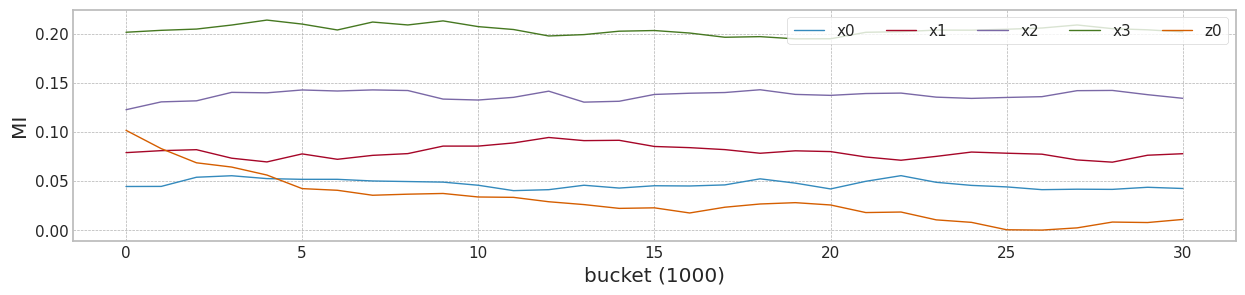

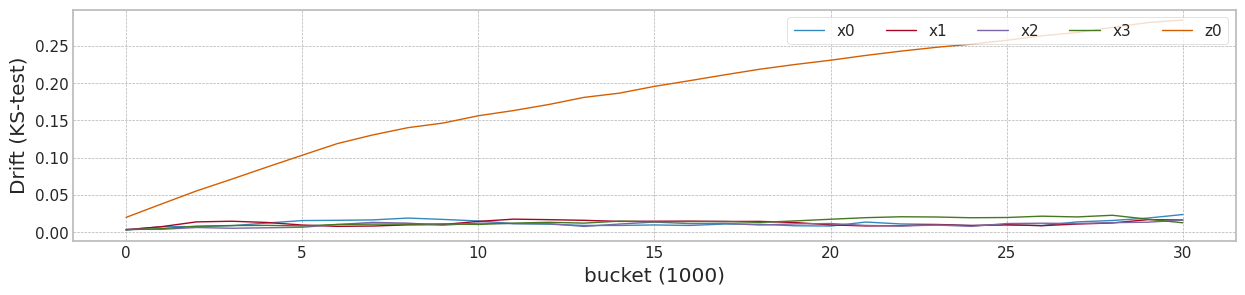

In [21]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
loss_mse = customLoss(mine).to(device)
optimizer = torch.optim.Adam(loss_mse.parameters(), lr=0.01)
plot_loss = []
plot_lmd = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss,lmd = loss_mse(x,y)
    mine_loss.sum().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())
    plot_lmd.append(lmd.cpu().data.numpy())

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

plot_lmd = np.asarray(plot_lmd)
df_lmd = pd.DataFrame(plot_lmd,columns=['lambda'])


cuda:0


  0%|          | 0/300 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
df_loss.plot()

In [ ]:
df_lmd.plot()

In [23]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.421766   0
1      0.447230  0.556479  0.629077  0.735705  0.529014   0
2      0.489501  0.704159  0.760582  0.582973  0.570549   0
3      0.581446  0.301839  0.443337  0.515173  0.396001   0
4      0.571642  0.639275  0.524701  0.583380  0.561748   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.185740  39
39996  0.426322  0.302644  0.484909  0.587518  0.721101  39
39997  0.374186  0.587769  0.624447  0.598315  0.489479  39
39998  0.470439  0.265430  0.218971  0.645349  1.258888  39
39999  0.654583  0.419378  0.800216  0.614031  1.055564  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 593.30it/s]


Test f1 score: 0.8763676148796499
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999359745907817
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 211.90it/s]


Test f1 score: 0.8806855636123929
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.93it/s]


mean of drift:
x0    0.263068
x1    0.191703
x2    0.127624
x3    0.151369
z0    0.183989
dtype: float64
Mean F1 for all data: 0.844434581709002


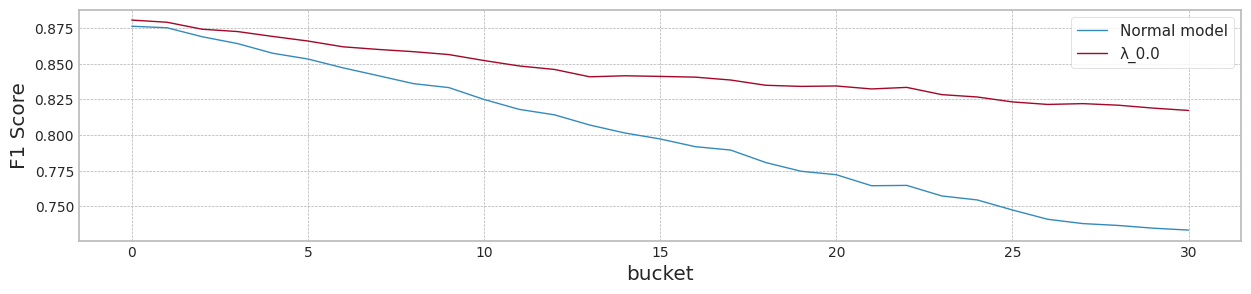

max_mean_lambda= 0.0


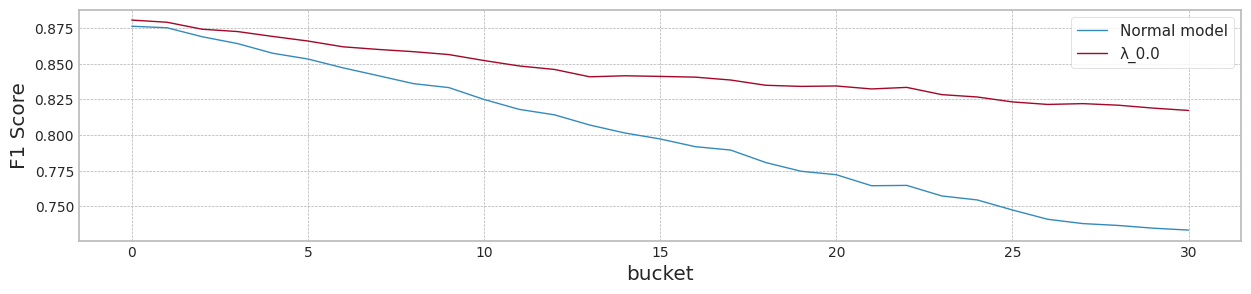

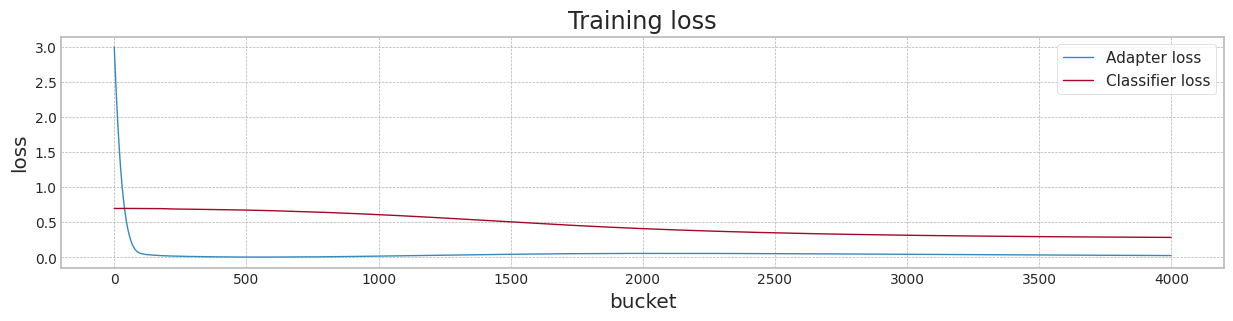

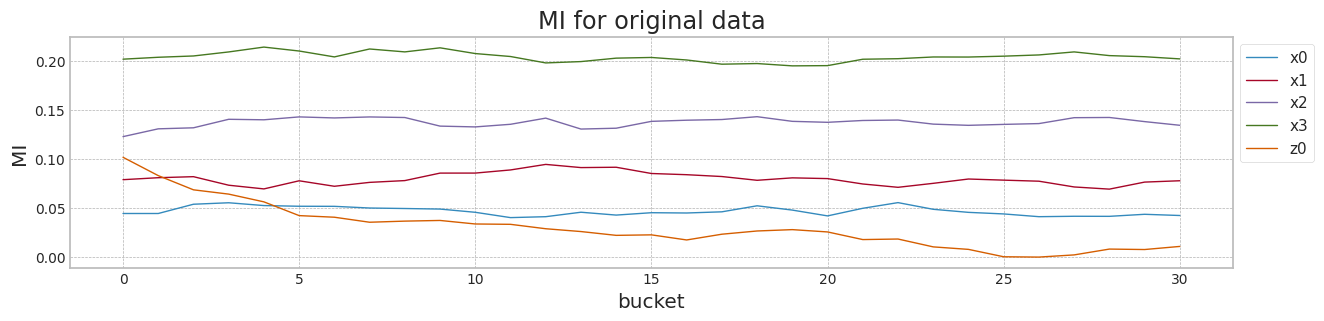

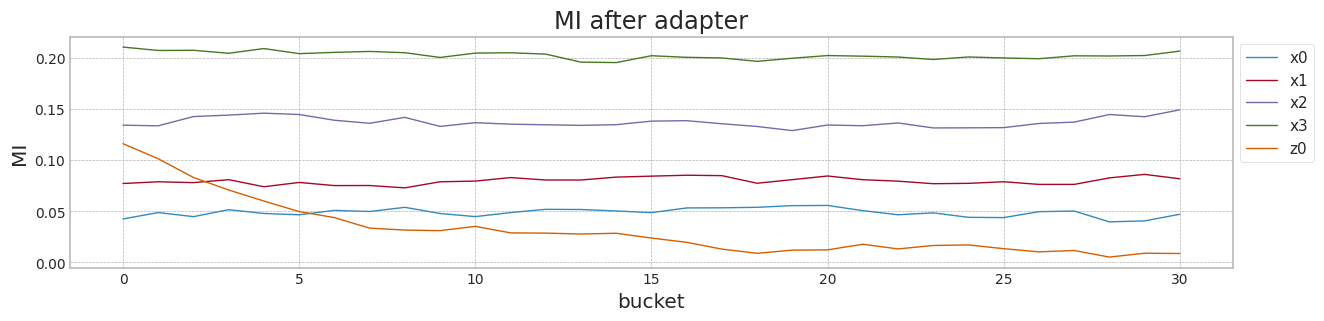

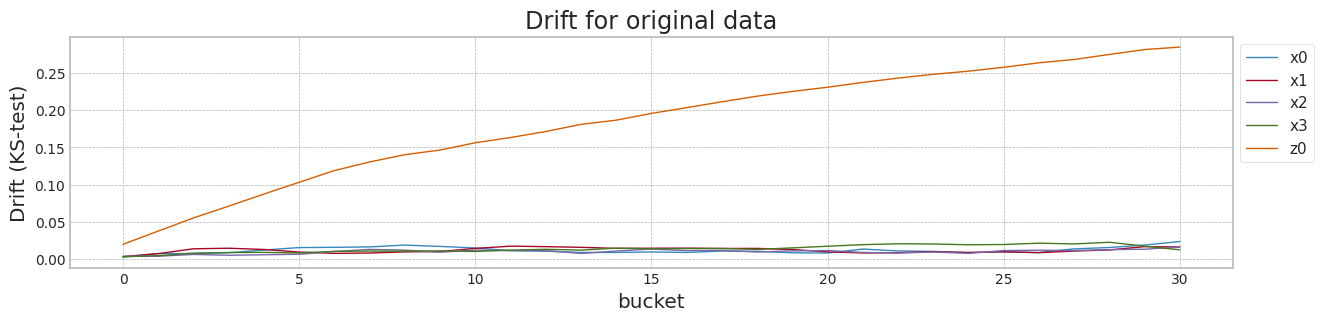

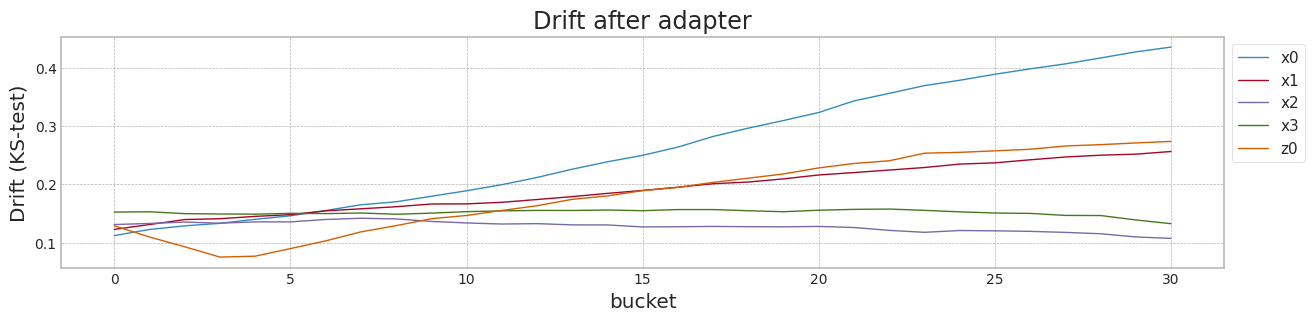

1    0.580414
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


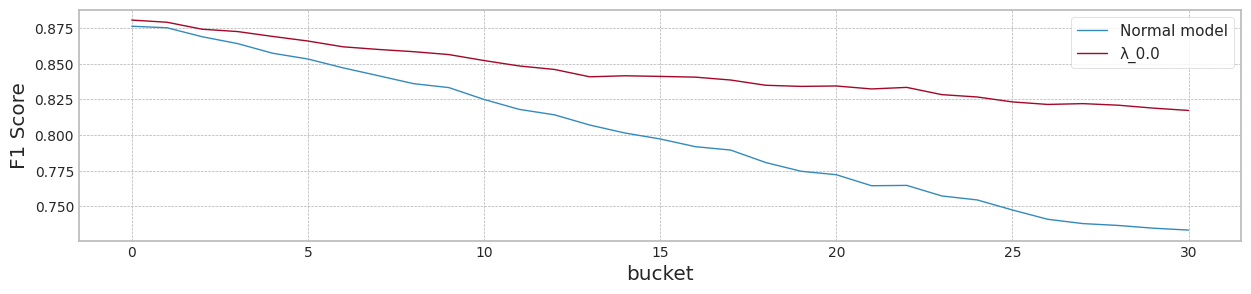

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.876368  0.876368  0.799936  0.733370    0.747456   
1                    0.0  0.880686  0.880686  0.844435  0.817285    0.748066   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0    0.093809    1.406225    0.181000    0.028441  ...    1.419276   
1    0.093752    1.407140    0.766889    0.041193  ...    1.572295   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.584127      0.053828      1.505461      0.549369      0.052727   
1      0.614881      0.058443      1.491382      0.580414      0.056866   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.496972      0.000000      0.000000           NaN  
1      1.488005      0.635222      0.014022      1.603486  

[2 rows x 68 columns]

In [72]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [73]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [74]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [75]:
x1.shape

(40000, 5)

In [76]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [77]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


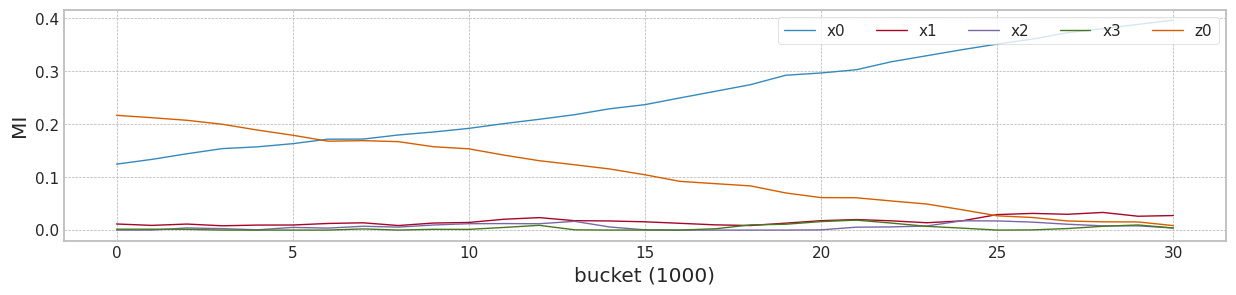

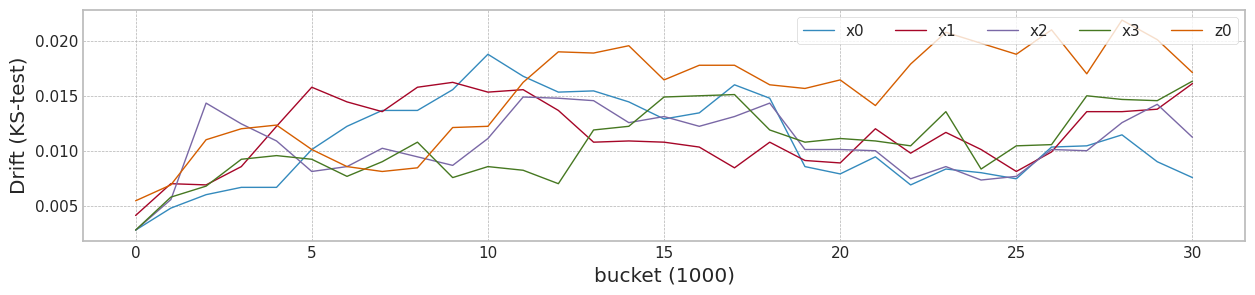

In [78]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [79]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 617.60it/s]


Test f1 score: 0.9662005741272339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790432735532113
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 210.93it/s]


Test f1 score: 0.9758889201613659
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.468380
x1    0.142151
x2    0.071717
x3    0.020215
z0    0.162738
dtype: float64
Mean F1 for all data: 0.8629300293844446


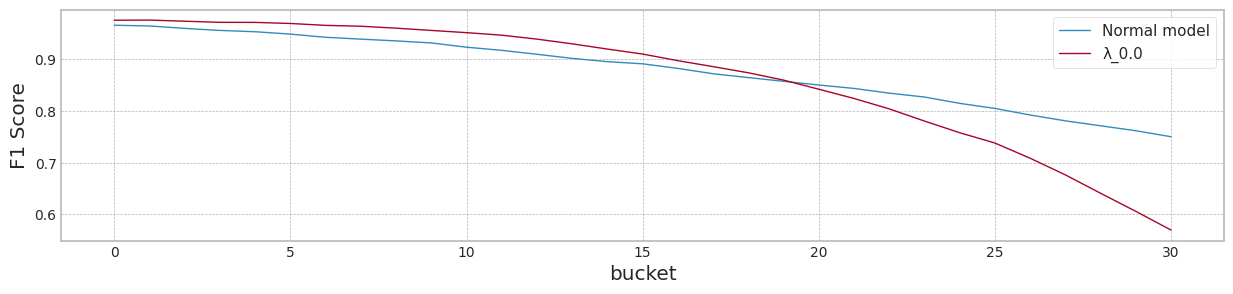

max_mean_lambda= 0.0


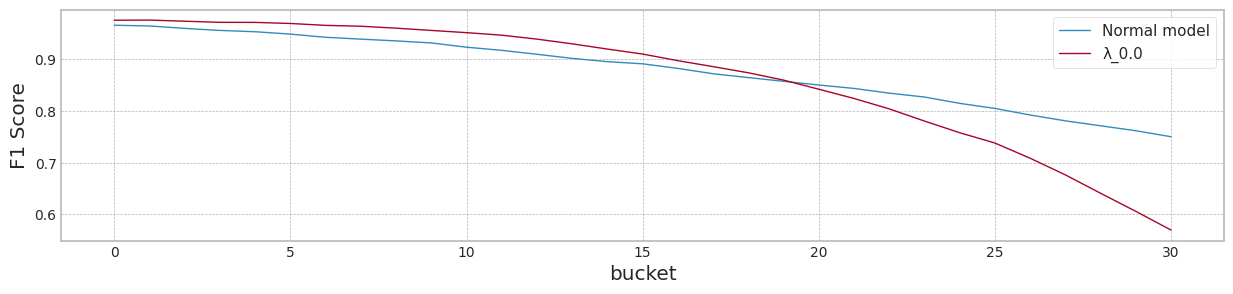

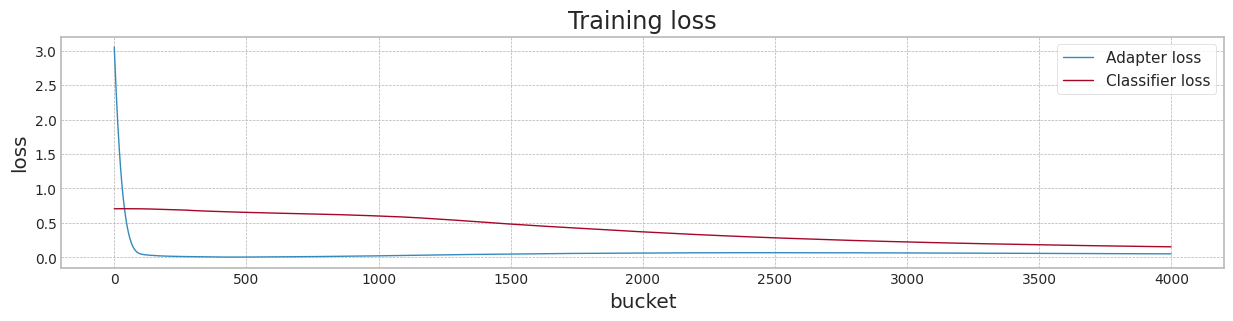

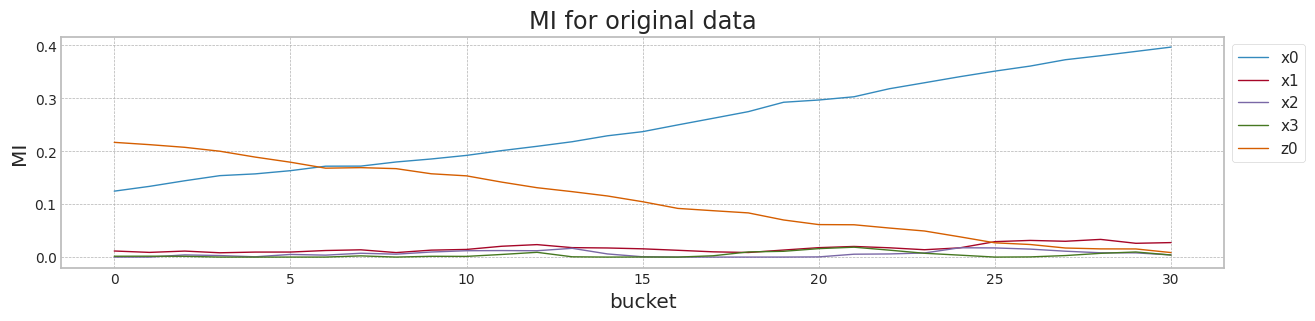

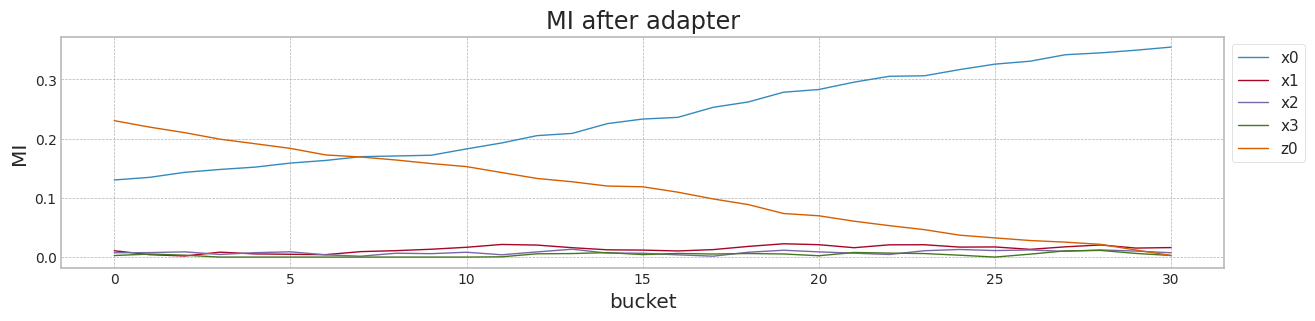

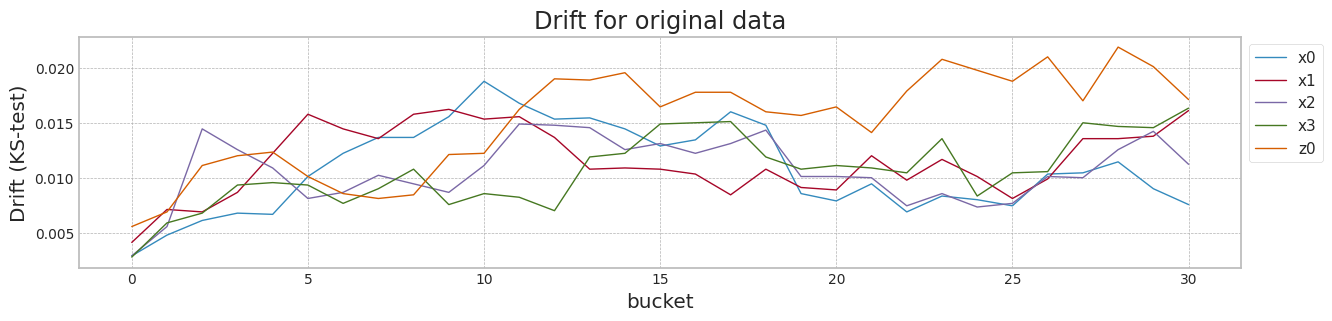

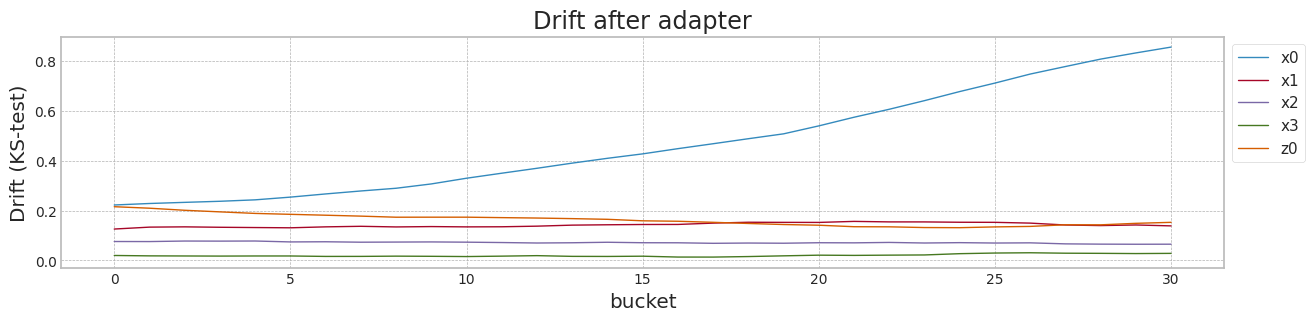

1    0.380974
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


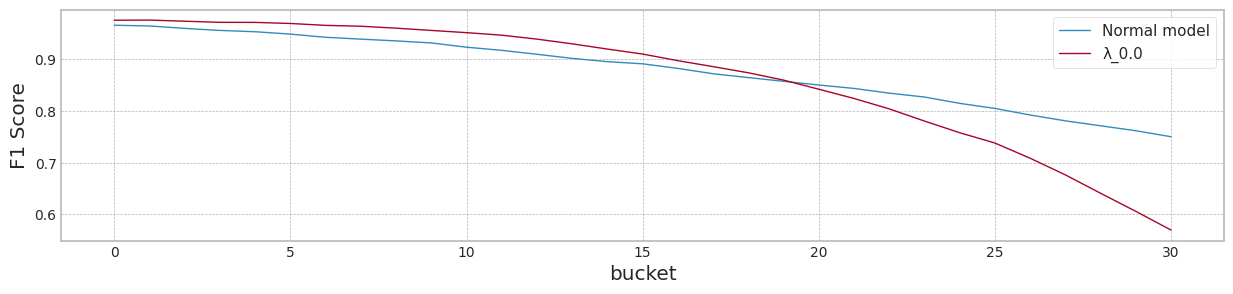

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.966201  0.966201  0.879043  0.750255    0.361798   
1                    0.0  0.975889  0.975889  0.862930  0.569478    0.361486   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0    0.102542    0.654025    0.096111    0.005867  ...    1.585123   
1    0.102255    0.657538    0.660556    0.076258  ...    1.428964   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.356049      0.089014      0.787555      0.354657      0.086642   
1      0.390379      0.092457      0.886500      0.380974      0.090654   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      0.804710      0.000000      0.000000           NaN  
1      0.881403      0.659222      0.078535       1.40117  

[2 rows x 68 columns]

In [80]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [81]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([2.5, 1.2, 0.9 , 1.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 10*cor_const * ii)
    e1 = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)


In [82]:
m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

9.231010910364422


19386

### 실험

MI Analysis MI Max 0.19778, Min 0.00159, Mean 0.07319, Std 0.07958
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


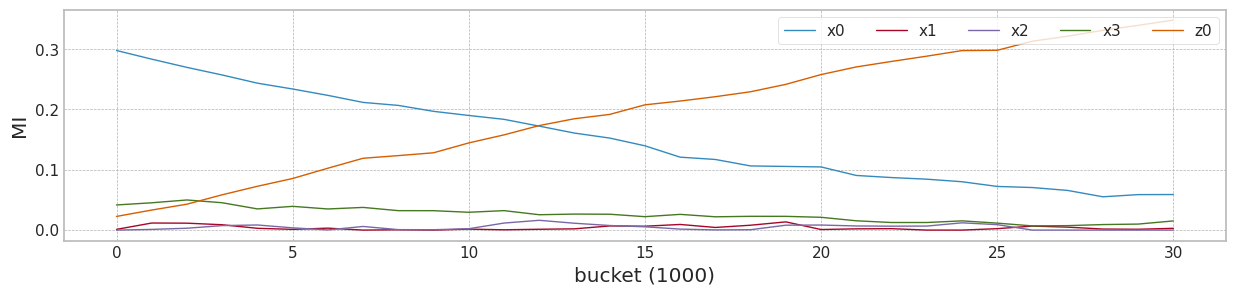

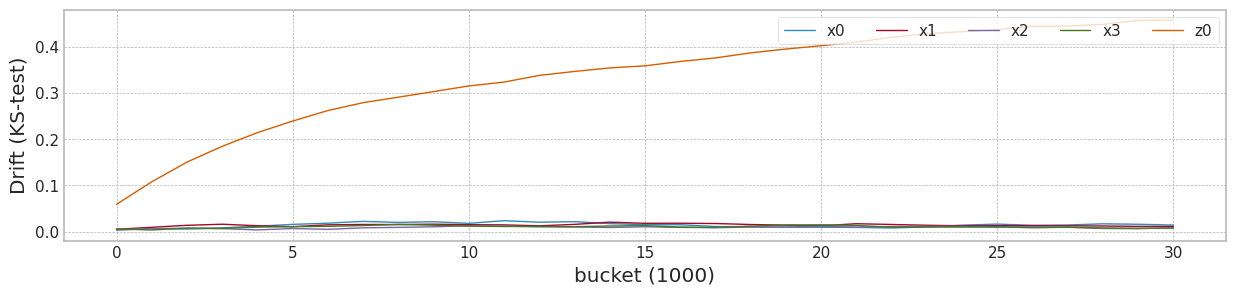

In [83]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [84]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.410279  0.209059  0.415497  0.727384  0.391721   0
1      0.457001  0.519404  0.479812  0.521037  0.401229   0
2      0.187431  0.428404  0.396307  0.408316  0.393364   0
3      0.676882  0.616554  0.624402  0.490002  0.423167   0
4      0.231854  0.479819  0.377091  0.562758  0.395391   0
...         ...       ...       ...       ...       ...  ..
39995  0.342999  0.553462  0.404624  0.588307 -0.255762  39
39996  0.399868  0.617391  0.449924  0.425269 -0.347659  39
39997  0.389933  0.496568  0.201780  0.495907  1.654762  39
39998  0.407933  0.571901  0.798504  0.658386  0.325860  39
39999  0.425227  0.455123  0.456839  0.491625  0.729285  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 584.32it/s]


Test f1 score: 0.9422071499222835
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.014294
x1    0.014247
x2    0.009111
x3    0.010627
z0    0.336724
dtype: float64
Mean F1 for all data: 0.9378763986662148
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 213.68it/s]


Test f1 score: 0.9541006202618884
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.15it/s]


mean of drift:
x0    0.334638
x1    0.126237
x2    0.114262
x3    0.221104
z0    0.372072
dtype: float64
Mean F1 for all data: 0.9328686601252809


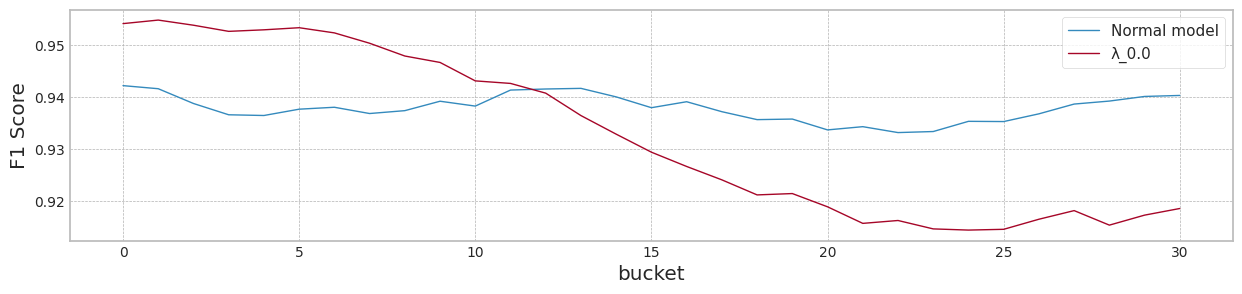

max_mean_lambda= 0.0


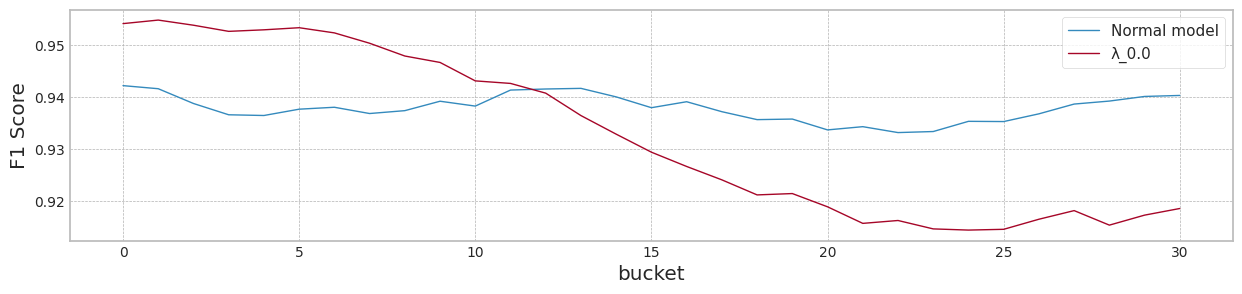

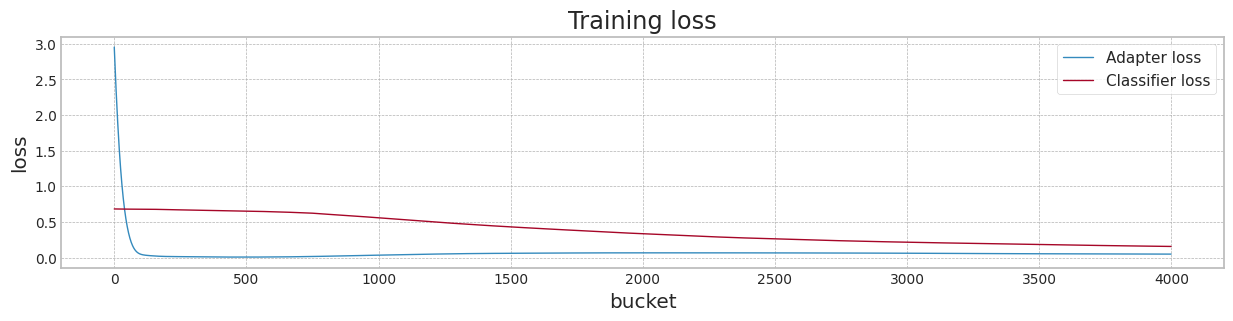

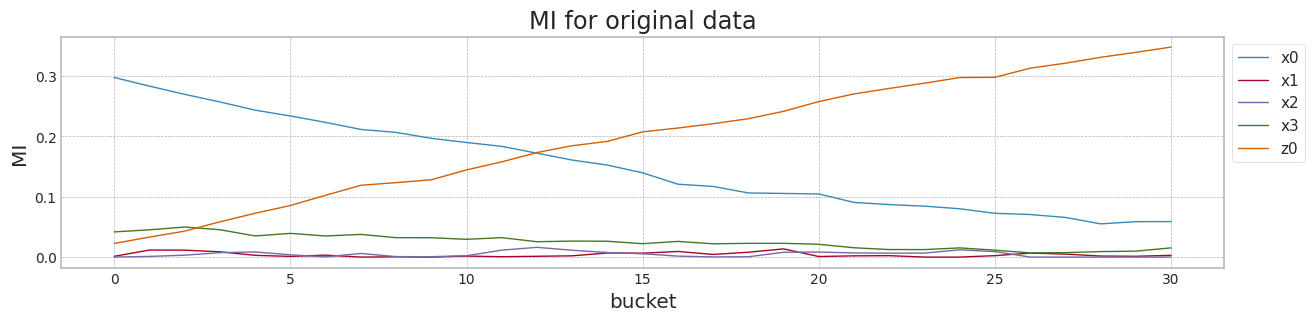

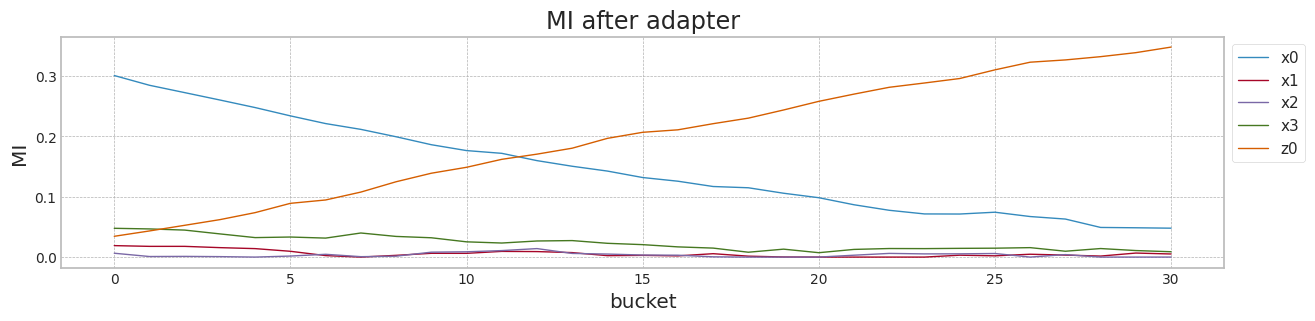

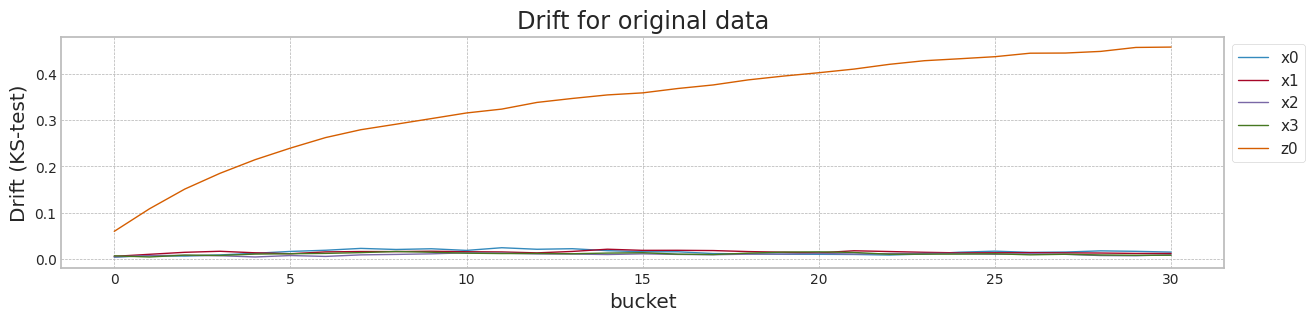

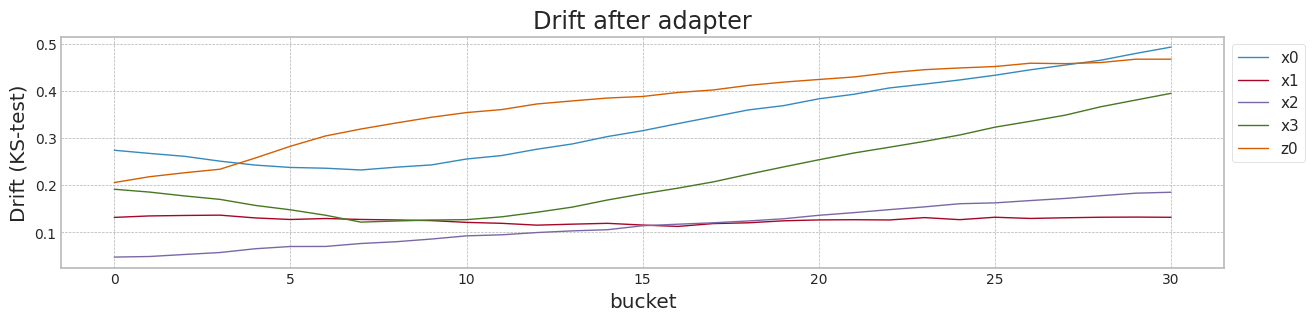

1    0.408656
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


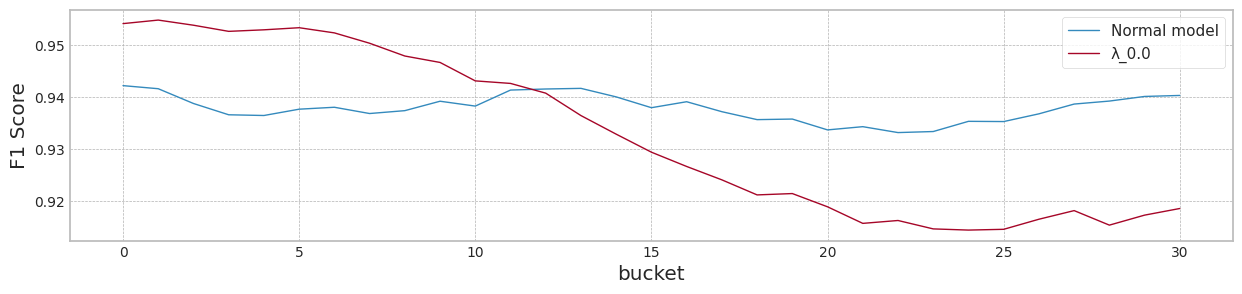

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.942207  0.942207  0.937876  0.940325    0.382206   
1                    0.0  0.954101  0.954101  0.932869  0.918646    0.380772   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0    0.125230    0.597607    0.477000    0.135991  ...    1.013100   
1    0.124638    0.599992    1.176889    0.137753  ...    1.527465   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.379631      0.116674      0.680939      0.363392      0.113602   
1      0.413755      0.115087      0.854521      0.408656      0.110570   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      0.603972      0.000000      0.000000           NaN  
1      0.891746      0.818667      0.074382       1.49519  

[2 rows x 68 columns]

In [85]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [86]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.53it/s]


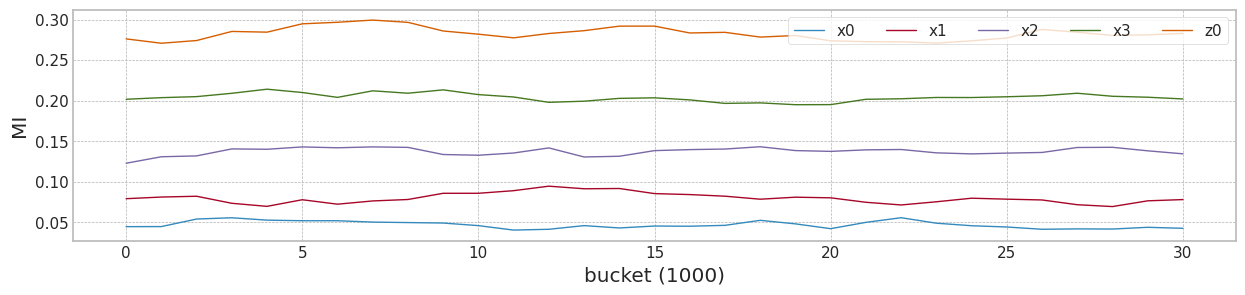

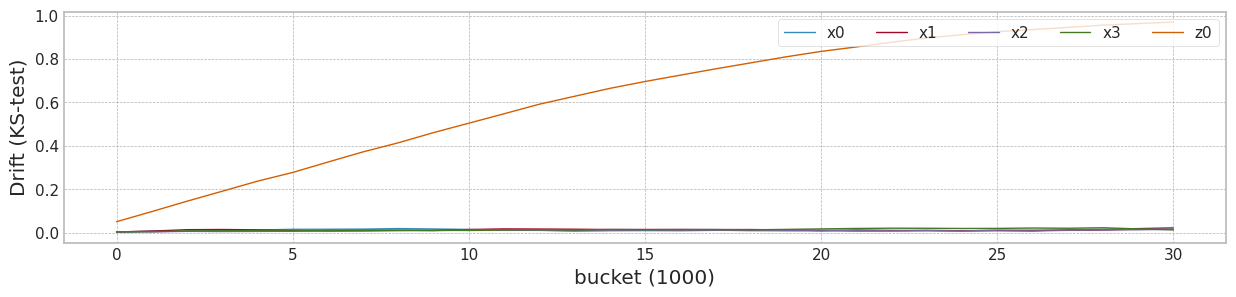

In [87]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [88]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 596.98it/s]


Test f1 score: 0.9102426454799226
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760588938342107
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:19<00:00, 210.27it/s]


Test f1 score: 0.9178850170385842
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.595369
x1    0.238147
x2    0.249573
x3    0.294875
z0    0.334287
dtype: float64
Mean F1 for all data: 0.9106377144623771


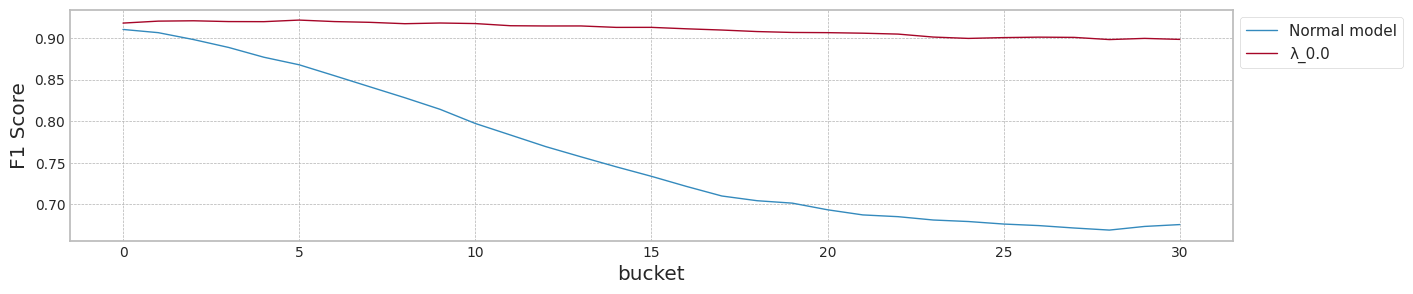

max_mean_lambda= 0.0


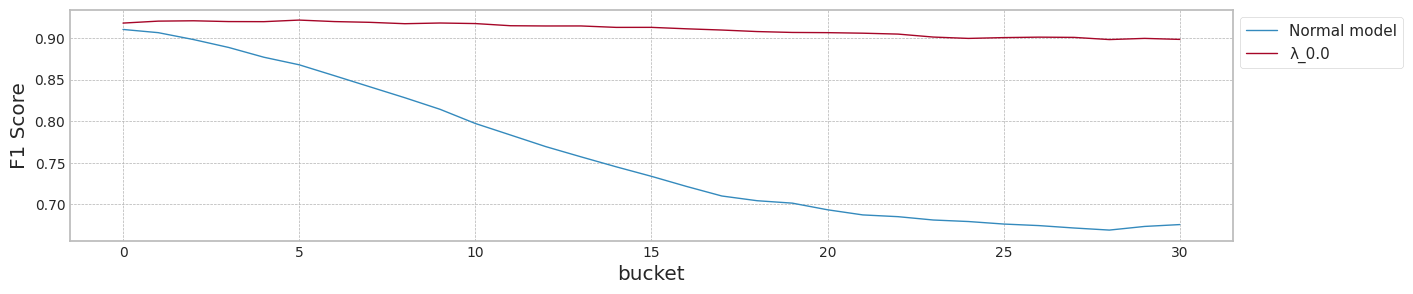

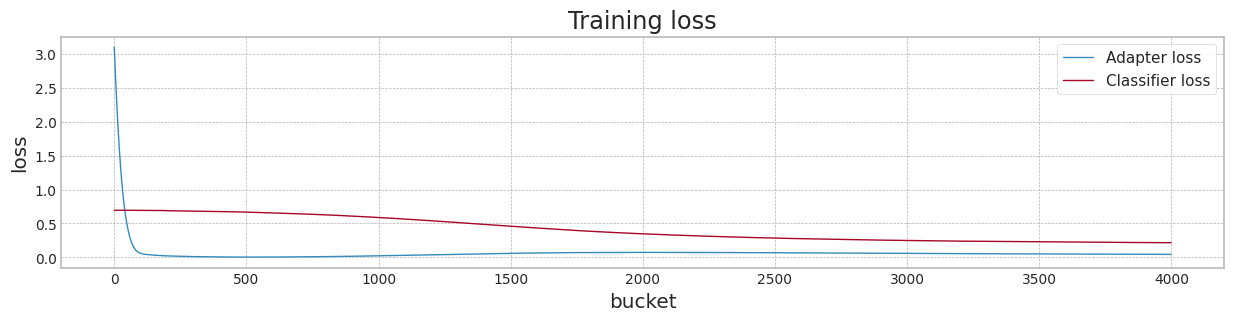

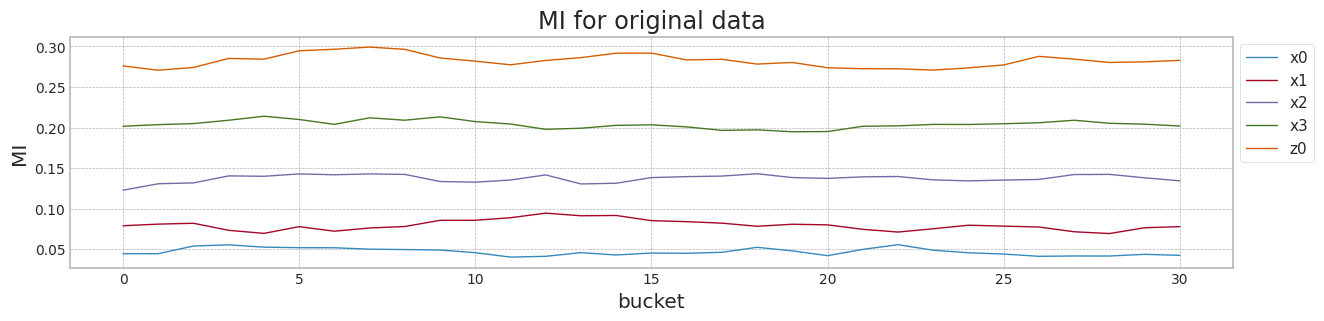

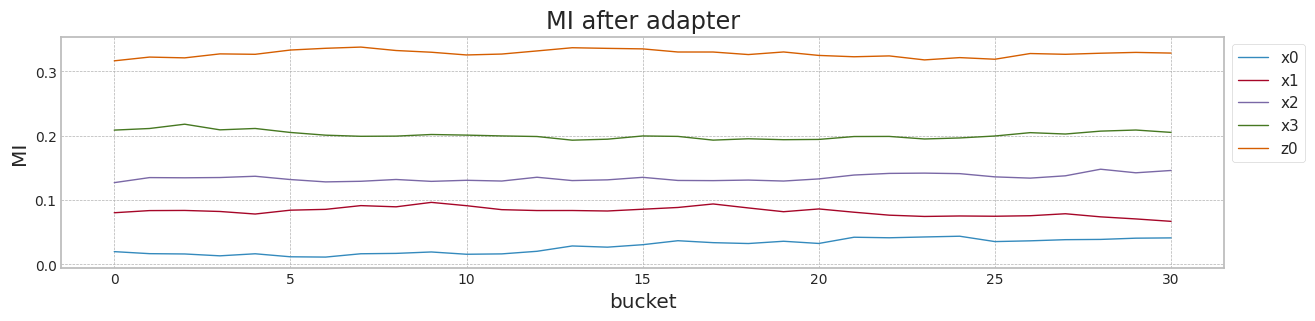

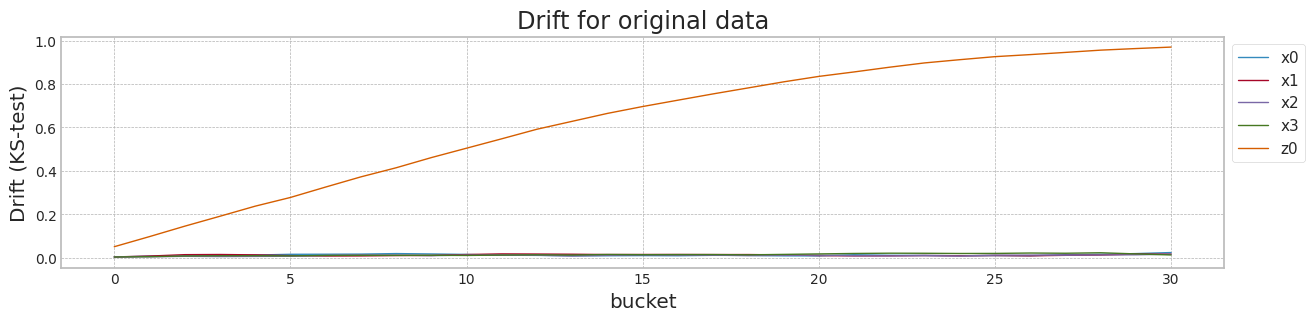

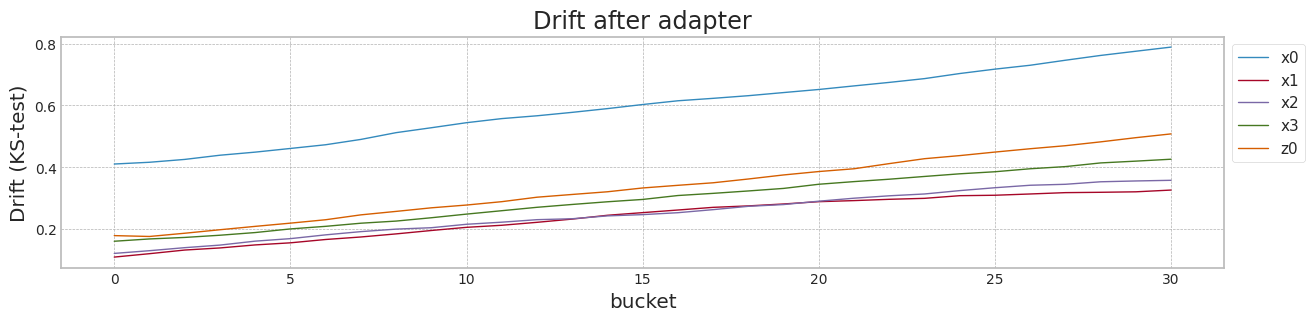

1    0.752749
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


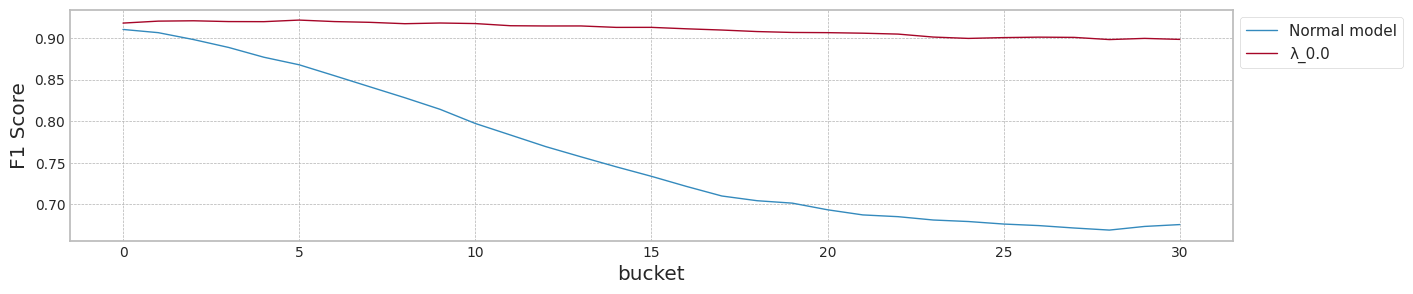

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.910243  0.910243  0.760589  0.675771    0.804112   
1                    0.0  0.917885  0.917885  0.910638  0.898278    0.806754   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0    0.112842    1.367717    0.302111    0.076825  ...    1.033720   
1    0.111940    1.374560    1.004889    0.113161  ...    1.507118   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.738968      0.084225      1.445611      0.723681      0.084119   
1      0.756520      0.102717      1.363948      0.752749      0.103410   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.437383      0.000000      0.000000           NaN  
1      1.355279      1.002333      0.109279      1.479645  

[2 rows x 68 columns]

In [89]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [90]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


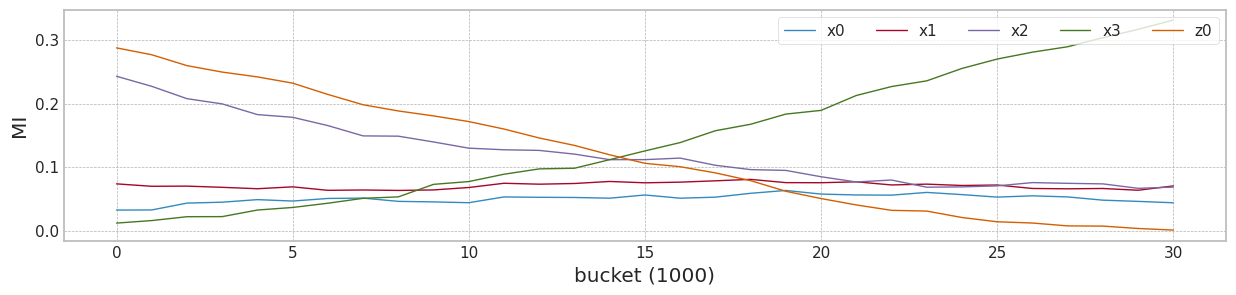

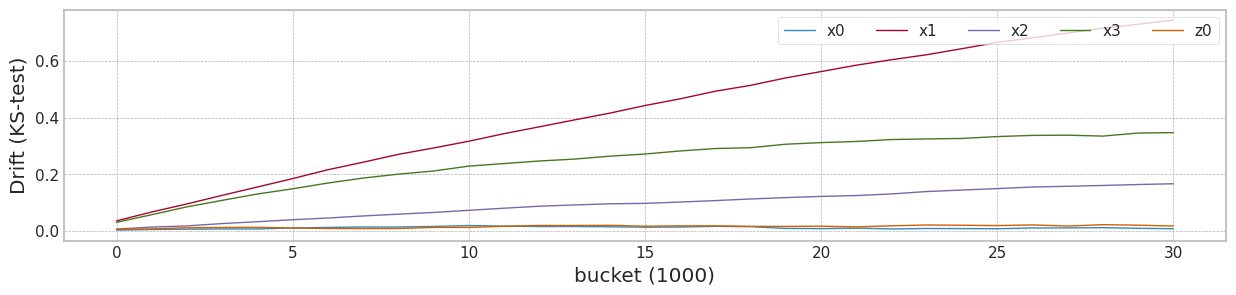

In [91]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 620.06it/s]


Test f1 score: 0.9227268417559494
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7642579759110337
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 211.92it/s]


Test f1 score: 0.9300411522633745
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.223742
x1    0.295591
x2    0.306806
x3    0.681086
z0    0.266713
dtype: float64
Mean F1 for all data: 0.8008387449753027


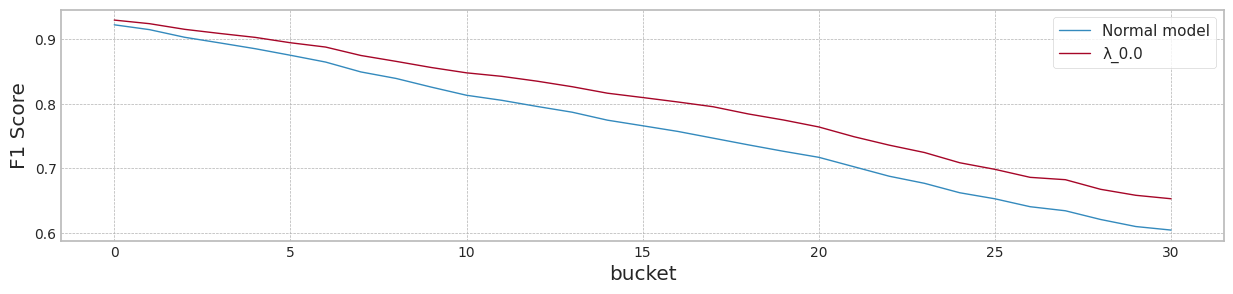

max_mean_lambda= 0.0


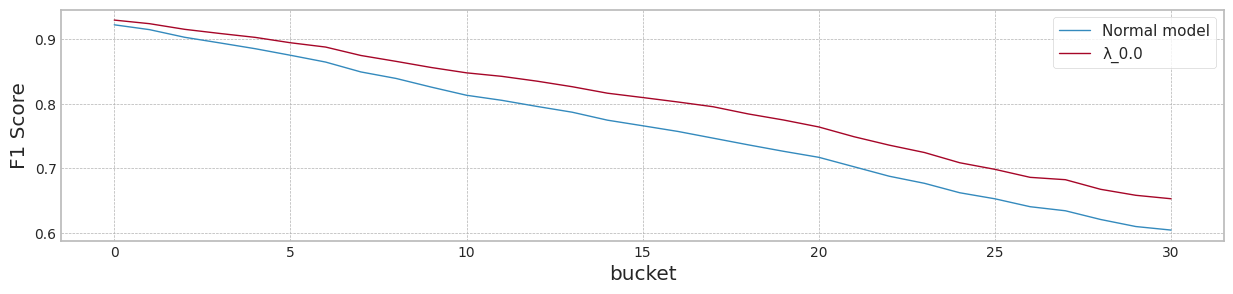

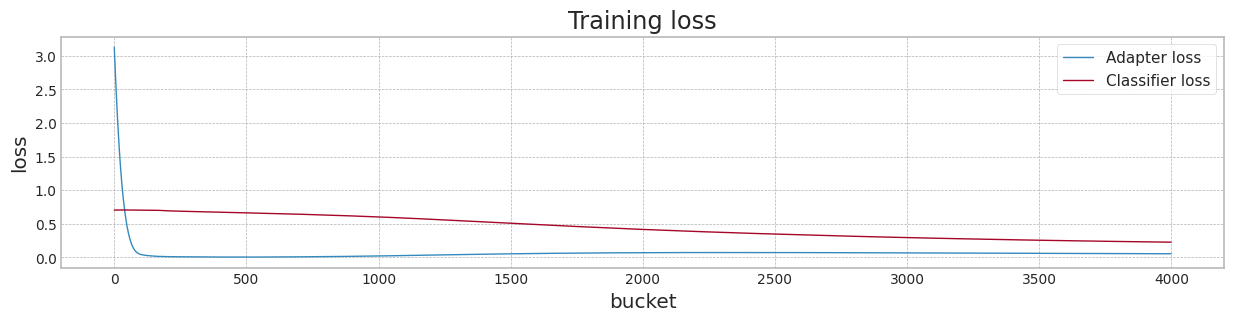

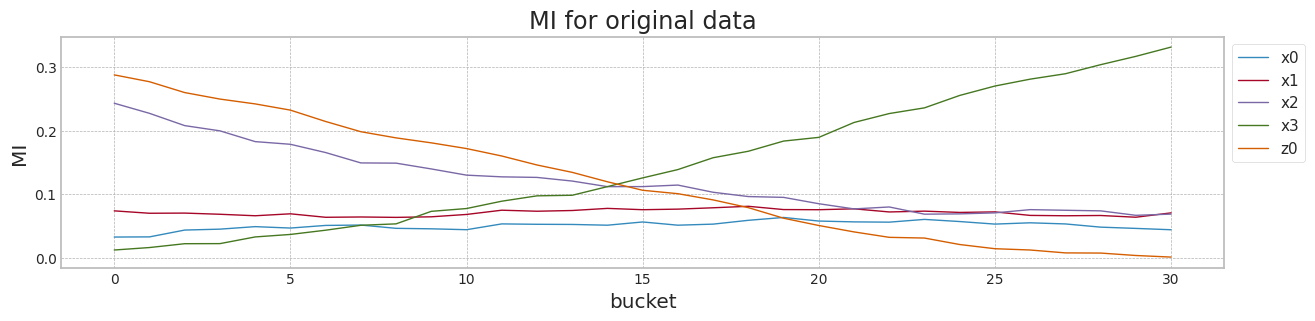

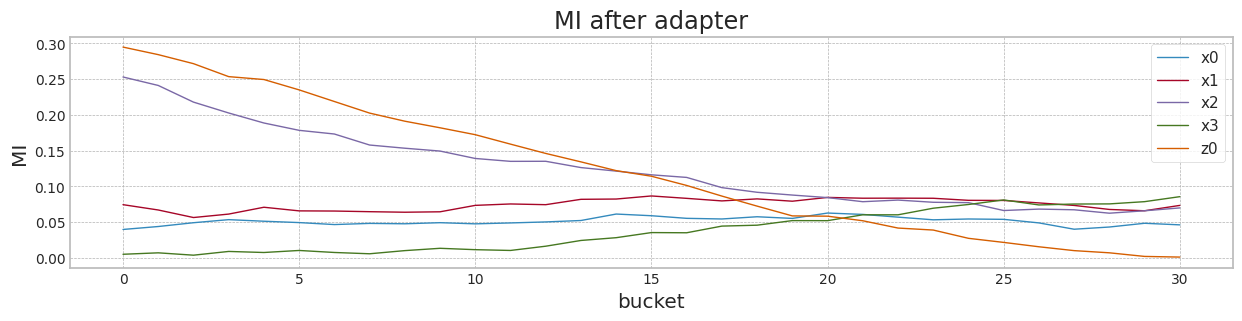

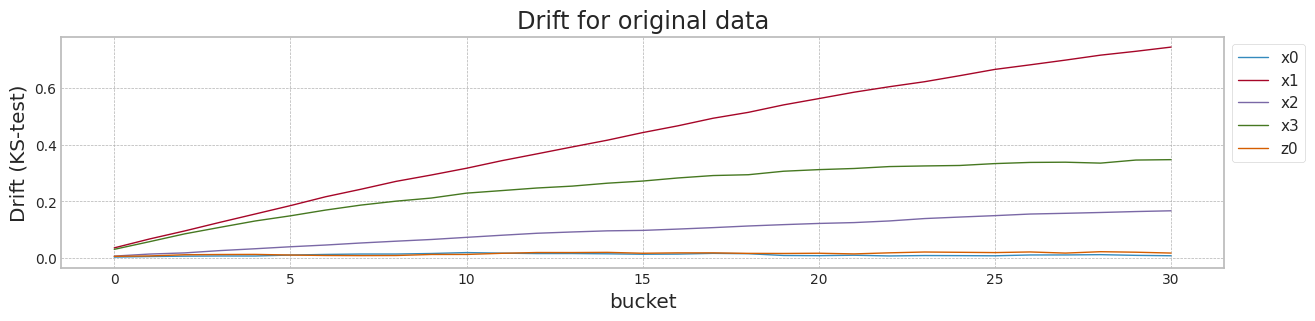

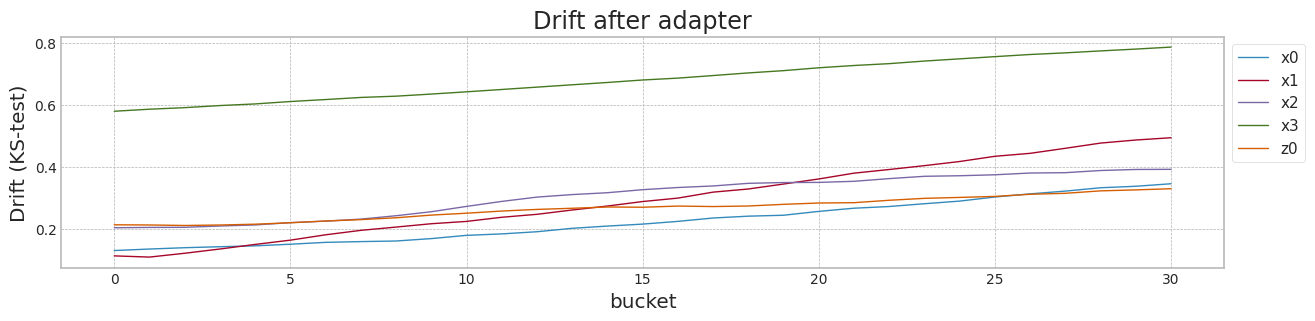

1    0.666965
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


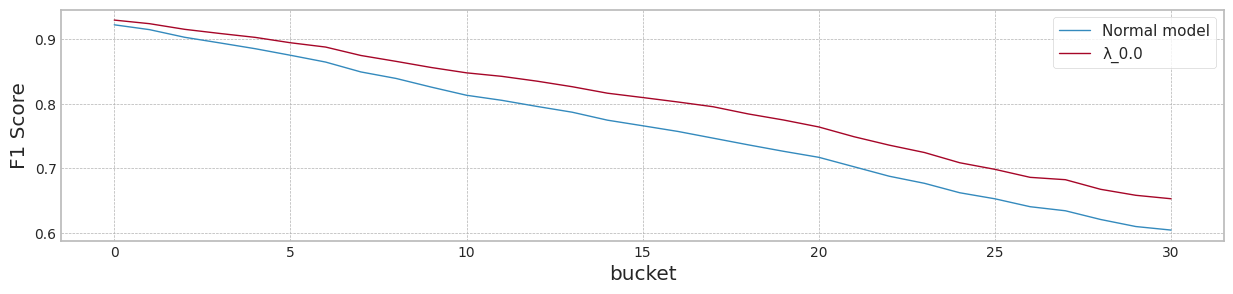

lambda   test_f1   init_f1   mean_f1  last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.922727  0.922727  0.764258  0.60401    0.740659   
1                    0.0  0.930041  0.930041  0.800839  0.65265    0.743599   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0    0.147834    1.064643       0.341    0.052764  ...    1.265173   
1    0.147018    1.079963       1.247    0.165075  ...    1.426548   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.674754      0.118196      1.196888      0.648423      0.113436   
1      0.686328      0.123345      1.161871      0.666965      0.117527   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.197710      0.000000      0.000000           NaN  
1      1.178659      1.237333      0.163584      1.426138  

[2 rows x 68 columns]

In [92]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)


## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [1]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [21]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [22]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [23]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [24]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [25]:

X[2010].shape

(11497, 81)

In [26]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [27]:
seed_everything(12)

X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries                  0.375327
last_fico_range_high        0.090427
last_pymnt_amnt             0.085496
total_rec_late_fee          0.038954
int_rate                    0.016850
                              ...   
F2                          0.000000
chargeoff_within_12_mths    0.000000
G1                          0.000000
G3                          0.000000
D3                          0.000000
Name: MI Scores, Length: 81, dtype: float64


In [28]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [29]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'fico_range_high',
 'DirectPay',
 'inq_last_6mths',
 'A2']

In [30]:
top_columns = ['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'term',
 'int_rate',
 'annual_inc',
 'debt_consolidation',
 'Y',
 'RENT']

In [31]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 1, 2, 3, 63, 80, 78]

In [32]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31592, Min 0.00474, Mean 0.11437, Std 0.10355
Dataset structure X_train, (50000, 9) X_test, (50000, 9) X_live (1269680, 9)
Truncate 49680 rows from live_set (1269680, 9)
Search MI & Drift...for X_live_set (122, 50000, 9)


100%|██████████| 122/122 [04:18<00:00,  2.12s/it]


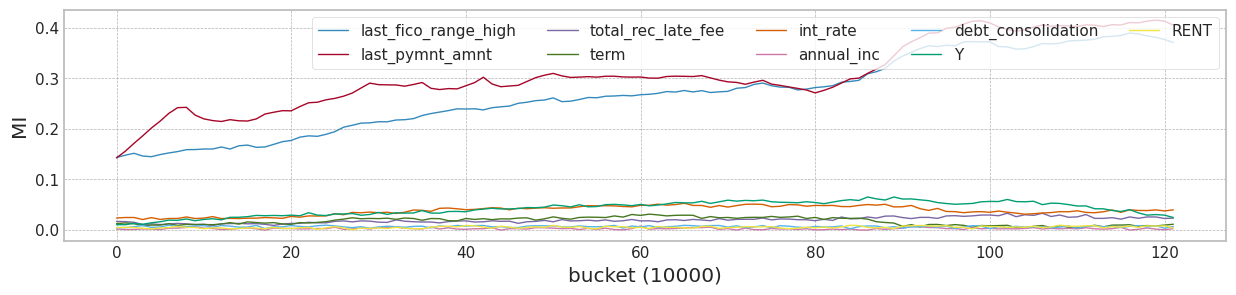

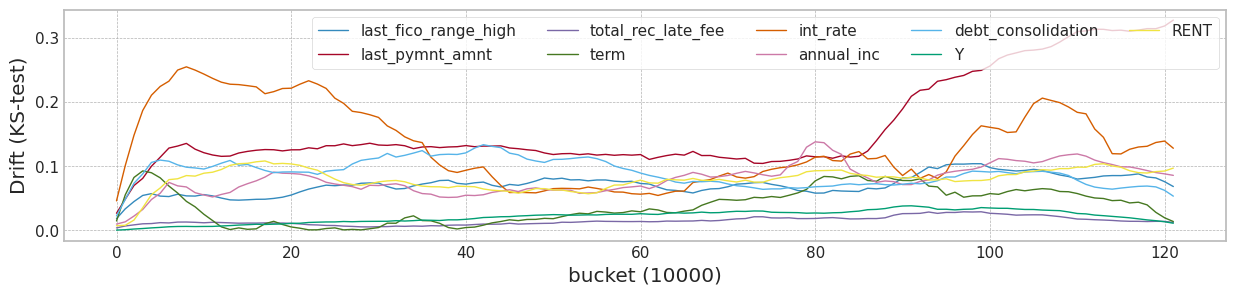

In [33]:
train_size = 50000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [34]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  term  \
0                    0.922353         0.023107            0.000000   0.0   
1                    0.857647         0.007334            0.000000   0.0   
2                    0.722353         0.267822            0.000000   0.0   
3                    0.863529         0.015264            0.000000   0.0   
4                    0.945882         0.019326            0.000000   0.0   
...                       ...              ...                 ...   ...   
1279675              0.910588         0.000189            0.083241   0.0   
1279676              0.851765         0.283658            0.000000   0.0   
1279677              0.898824         0.235068            0.000000   0.0   
1279678              0.916471         0.682716            0.000000   0.0   
1279679              0.875294         0.264953            0.000000   1.0   

         int_rate  annual_inc  debt_consolidation    Y  RENT    b  
0        0.418593    0.006324                 1.0  0.0   1.0    0  
1        0.347201    0.003656                 1.0  0.0   1.0    0  
2        0.472008    0.009727                 0.0  0.0   0.0    0  
3        0.543400    0.015330                 1.0  0.0   1.0    0  
4        0.329224    0.016831                 1.0  0.0   0.0    0  
...           ...         ...                 ...  ...   ...  ...  
1279675  0.231638    0.014330                 0.0  0.0   1.0  255  
1279676  0.231638    0.024337                 0.0  0.0   0.0  255  
1279677  0.130971    0.006074                 0.0  0.0   1.0  255  
1279678 -0.005136    0.006825                 1.0  0.0   0.0  255  
1279679  1.303030    0.003322                 1.0  0.0   1.0  255  

[1279680 rows x 10 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:09<00:00, 404.21it/s]


Test f1 score: 0.9264534204996496
X_live.shape (1269680, 10)
Truncate 49680 rows from live_set (1269680, 10)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 10])


100%|██████████| 122/122 [04:20<00:00,  2.13s/it]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
term                    0.038424
int_rate                0.135921
annual_inc              0.103518
debt_consolidation      0.089735
Y                       0.021640
RENT                    0.079510
dtype: float64
Mean F1 for all data: 0.9217253836051856
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:54<00:00, 73.62it/s]


Test f1 score: 0.9368536652329091
X_live.shape (1269680, 10)
Truncate 49680 rows from live_set (1269680, 10)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 10])


100%|██████████| 122/122 [04:14<00:00,  2.09s/it]


mean of drift:
last_fico_range_high    0.634208
last_pymnt_amnt         0.619795
total_rec_late_fee      0.987830
term                    0.722520
int_rate                0.172343
annual_inc              0.974133
debt_consolidation      0.519727
Y                       0.995220
RENT                    0.523480
dtype: float64
Mean F1 for all data: 0.9070815809238538


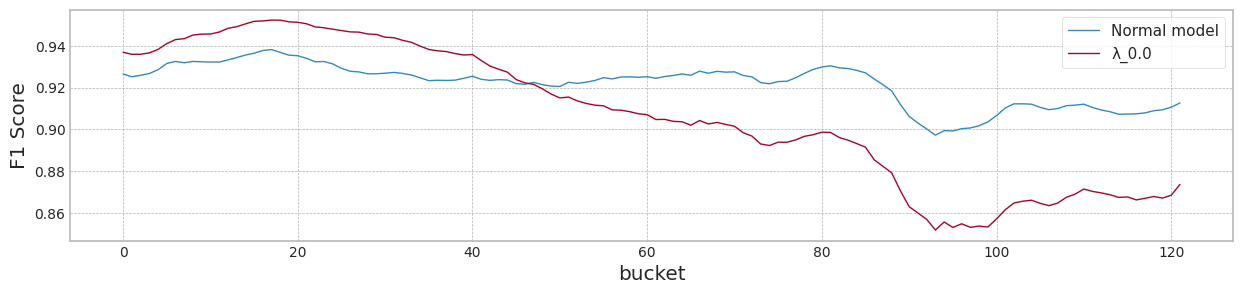

max_mean_lambda= 0.0


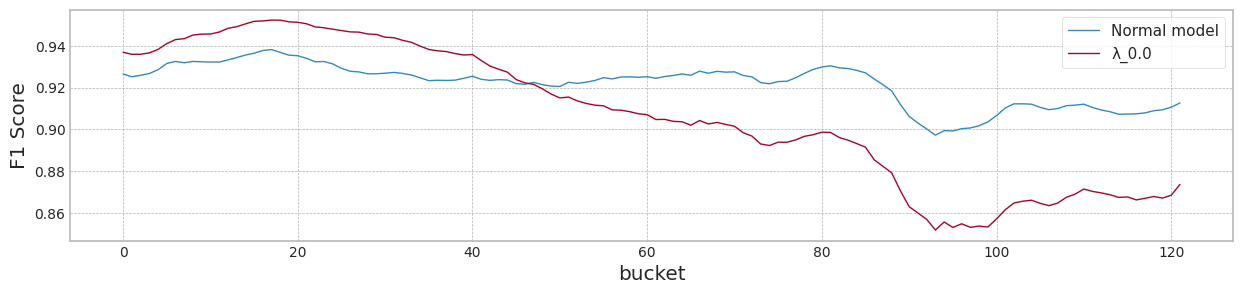

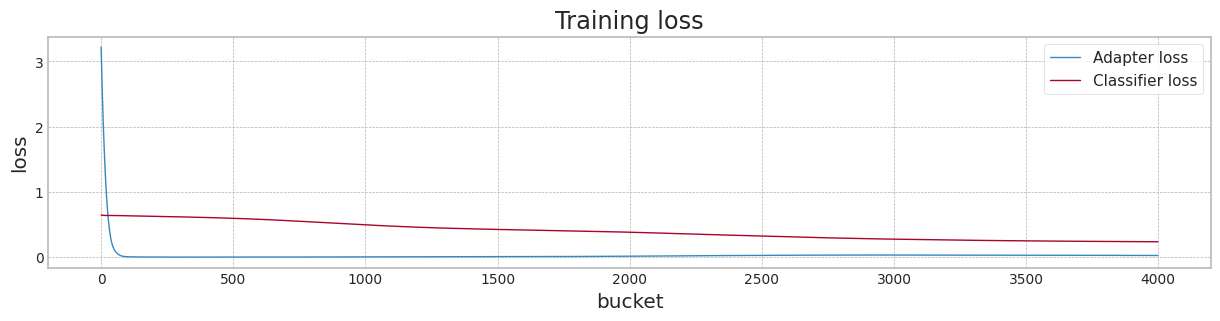

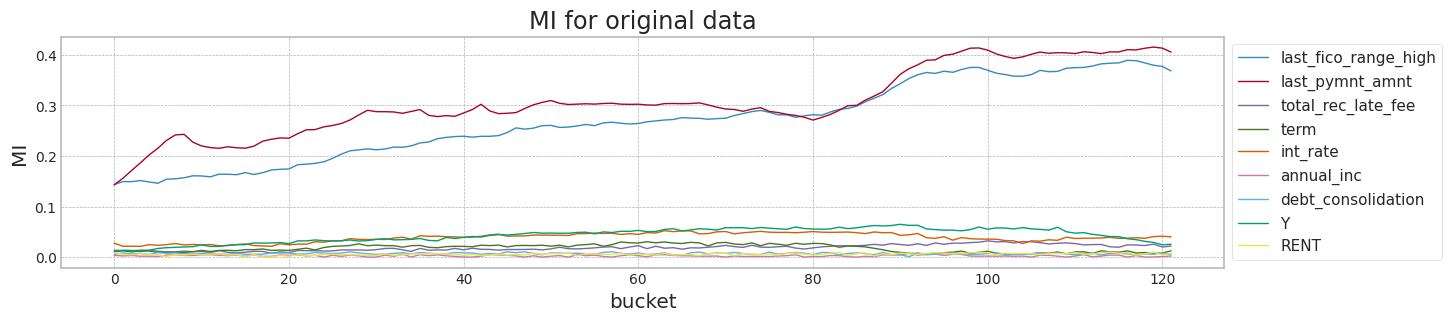

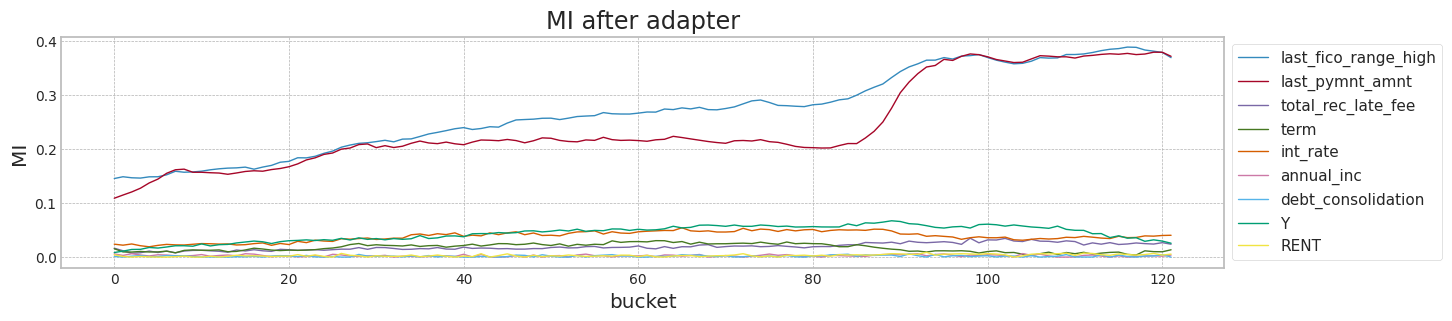

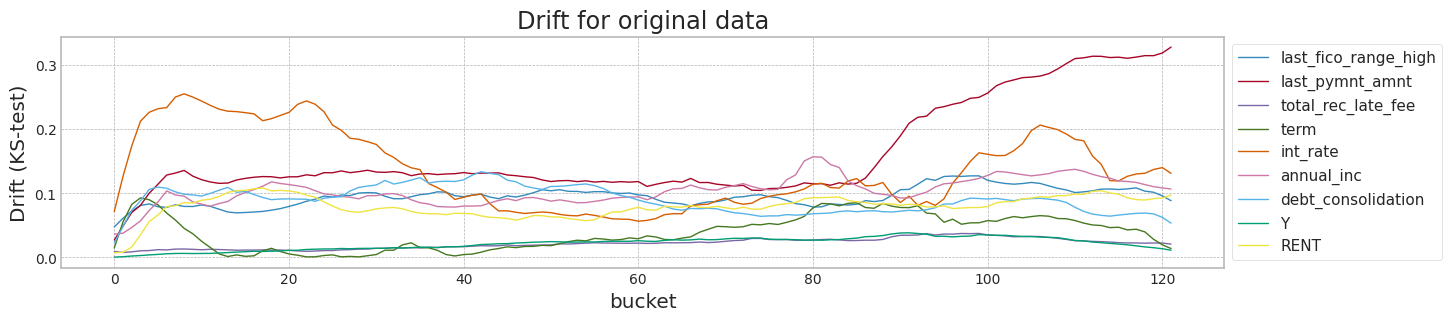

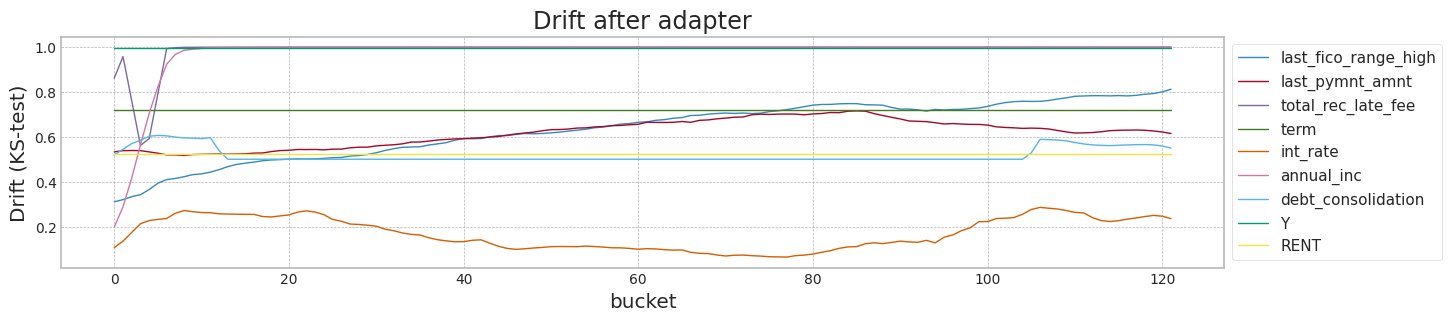

1    0.329063
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


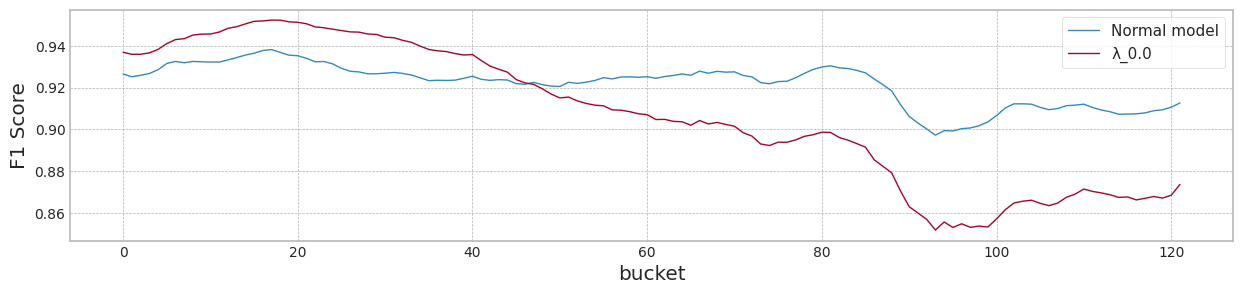

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.926453  0.926453  0.921725  0.912635    0.214879   
1                    0.0  0.936854  0.936854  0.907082  0.873700    0.213396   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR9.0)  \
0    0.029021    1.463312     0.48980    0.043796  ...    1.714951   
1    0.028848    1.467261     5.05198    0.270255  ...    2.068707   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.343392      0.049878      1.495925      0.361875      0.054932   
1      0.312684      0.043764      1.549639      0.329063      0.049442   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.421781       0.00000      0.000000           NaN  
1      1.450170       4.80162      0.281393      2.043135  

[2 rows x 74 columns]

In [35]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)
result_df

### #2

In [ ]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'fico_range_high',
 'DirectPay',
 'inq_last_6mths',
 'A2']

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 6, 79, 7, 24]

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

MI Analysis MI Max 0.31562, Min 0.00024, Mean 0.09055, Std 0.11223
Dataset structure X_train, (50000, 9) X_test, (50000, 9) X_live (1269680, 9)
Truncate 49680 rows from live_set (1269680, 9)
Search MI & Drift...for X_live_set (122, 50000, 9)


100%|██████████| 122/122 [04:19<00:00,  2.12s/it]


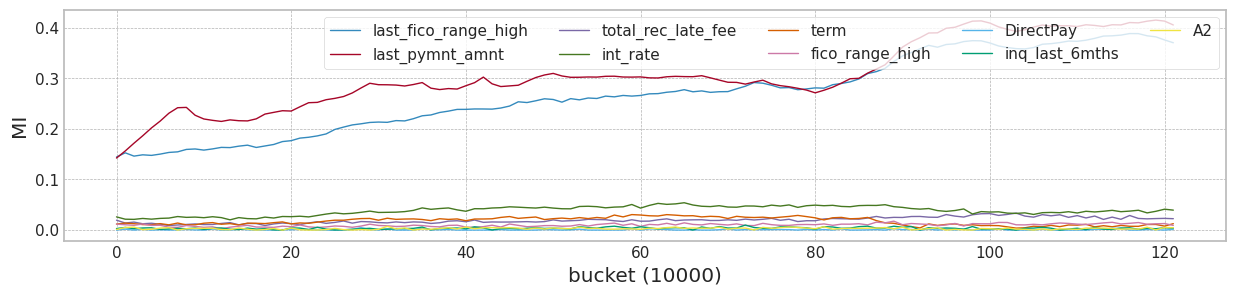

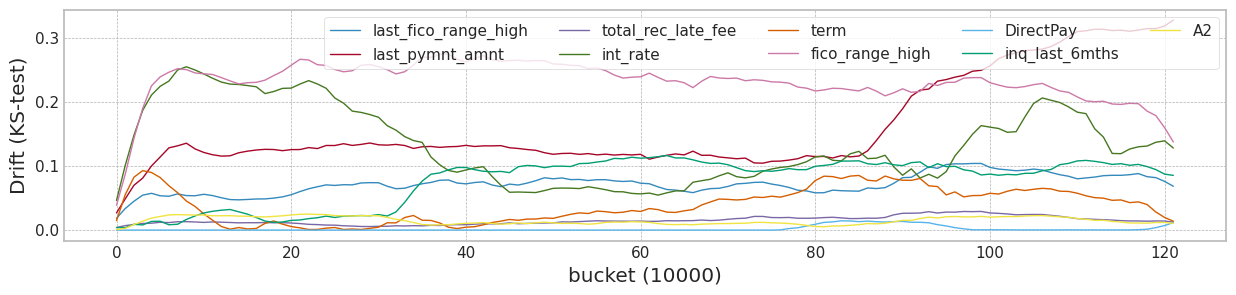

In [ ]:
train_size = 50000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [ ]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023107            0.000000  0.418593   
1                    0.857647         0.007334            0.000000  0.347201   
2                    0.722353         0.267822            0.000000  0.472008   
3                    0.863529         0.015264            0.000000  0.543400   
4                    0.945882         0.019326            0.000000  0.329224   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000189            0.083241  0.231638   
1279676              0.851765         0.283658            0.000000  0.231638   
1279677              0.898824         0.235068            0.000000  0.130971   
1279678              0.916471         0.682716            0.000000 -0.005136   
1279679              0.875294         0.264953            0.000000  1.303030   

         term  fico_range_high  DirectPay  inq_last_6mths   A2    b  
0         0.0         0.107527        0.0           0.250  0.0    0  
1         0.0         0.537634        0.0           0.375  0.0    0  
2         0.0         0.268817        0.0           0.125  0.0    0  
3         0.0         0.000000        0.0           0.250  0.0    0  
4         0.0         0.510753        0.0           0.000  0.0    0  
...       ...              ...        ...             ...  ...  ...  
1279675   0.0         0.215054        0.0           0.000  0.0  255  
1279676   0.0         0.403226        0.0           0.000  0.0  255  
1279677   0.0         0.241935        0.0           0.125  0.0  255  
1279678   0.0         0.618280        0.0           0.000  0.0  255  
1279679   1.0         0.295699        0.0           0.125  0.0  255  

[1279680 rows x 10 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.31it/s]


Test f1 score: 0.9194162088665196
X_live.shape (1269680, 10)
Truncate 49680 rows from live_set (1269680, 10)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 10])


100%|██████████| 122/122 [04:18<00:00,  2.12s/it]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
int_rate                0.135921
term                    0.038424
fico_range_high         0.284823
DirectPay               0.001982
inq_last_6mths          0.076795
A2                      0.014848
dtype: float64
Mean F1 for all data: 0.8994236397286528
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [02:10<00:00, 30.60it/s]


Test f1 score: 0.9279494507457355


<Figure size 1500x300 with 0 Axes>

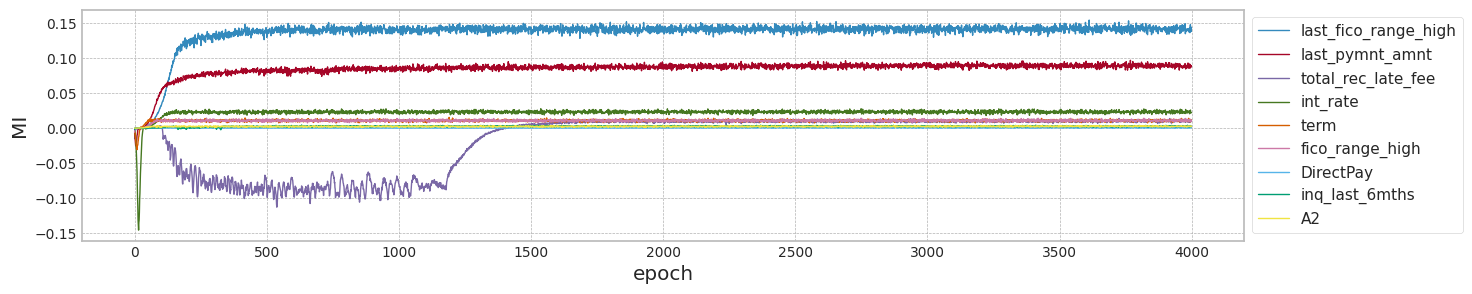

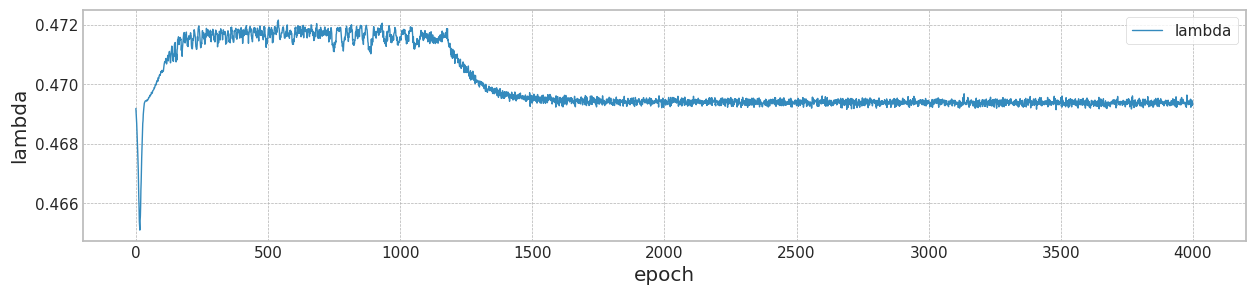

X_live.shape (1269680, 10)
Truncate 49680 rows from live_set (1269680, 10)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 10])


100%|██████████| 122/122 [04:12<00:00,  2.07s/it]


mean of drift:
last_fico_range_high    0.314202
last_pymnt_amnt         0.659762
total_rec_late_fee      0.978815
int_rate                0.295129
term                    0.722520
fico_range_high         0.270503
DirectPay               1.000000
inq_last_6mths          0.602295
A2                      0.945886
dtype: float64
Mean F1 for all data: 0.8739535609053419


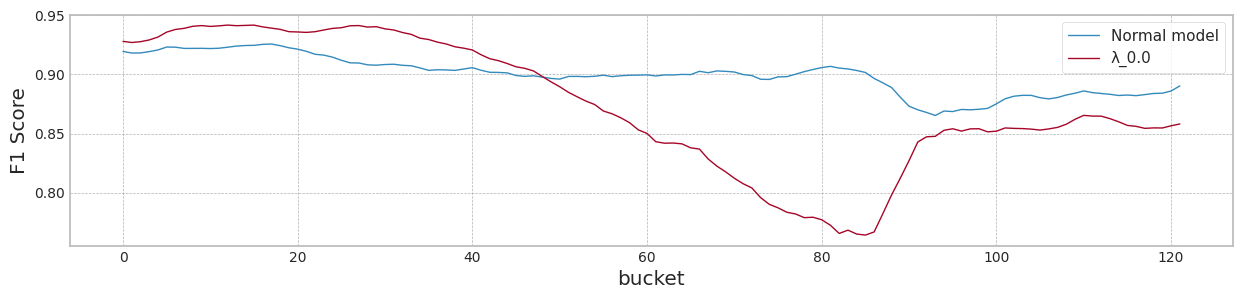

max_mean_lambda= 0.0


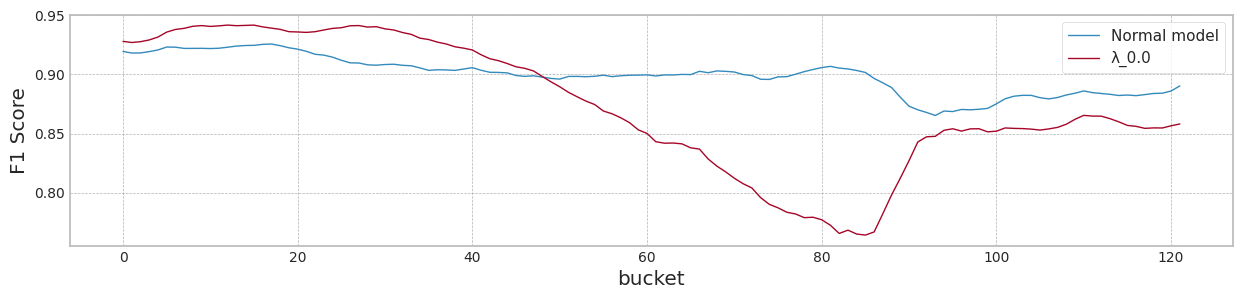

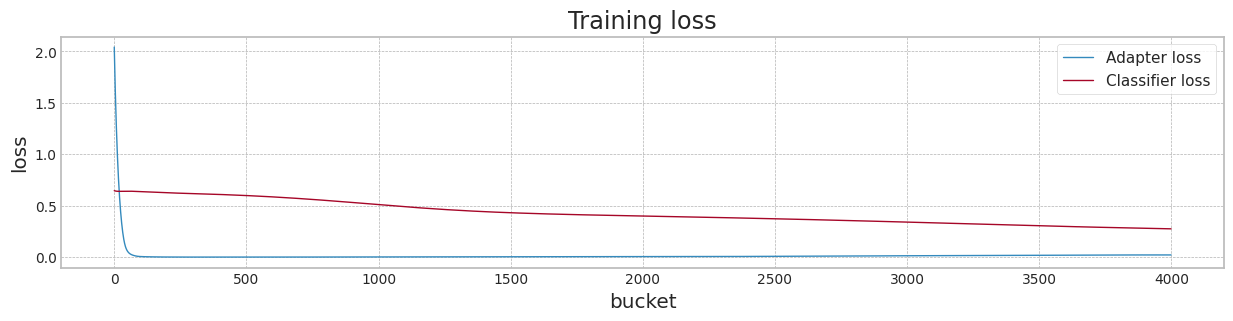

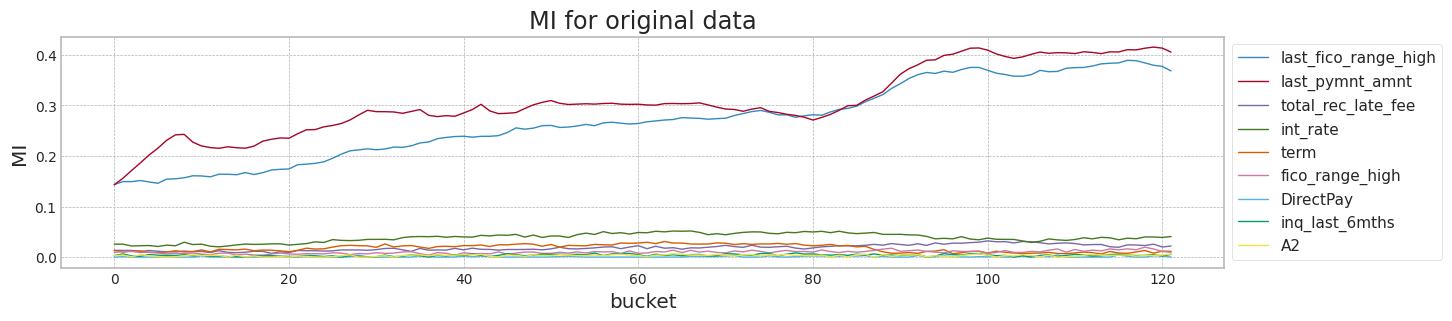

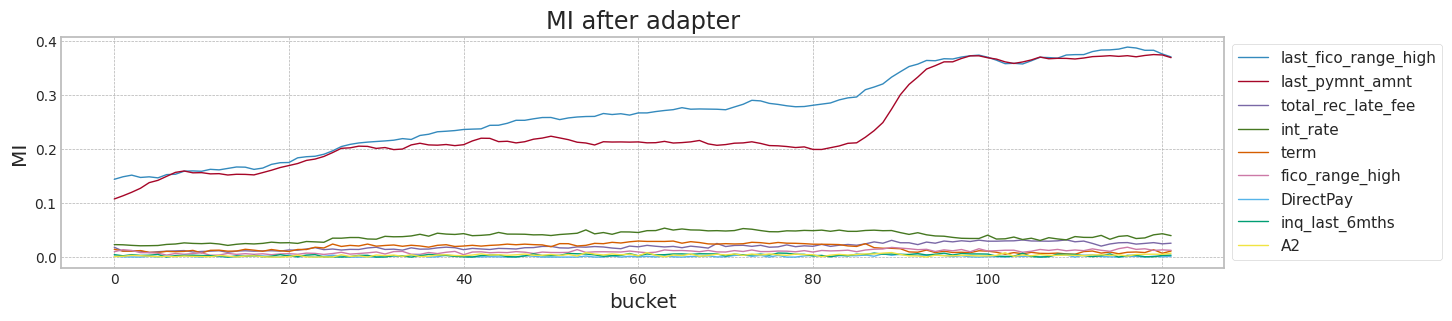

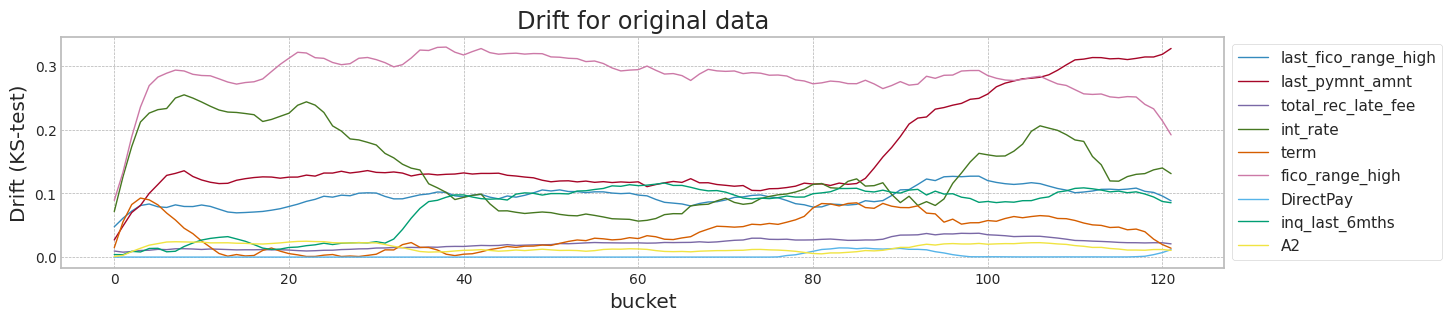

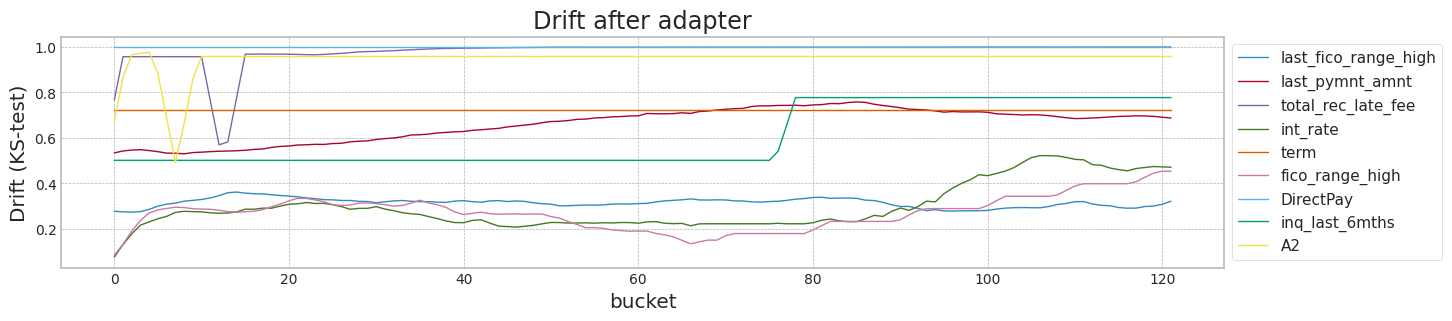

1    0.323929
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


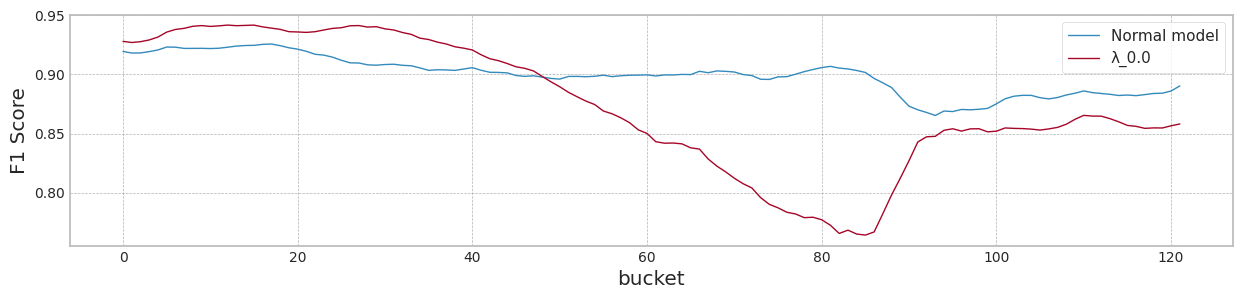

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.919416  0.919416  0.899424  0.890277    0.219983   
1                    0.0  0.927949  0.927949  0.873954  0.858089    0.225197   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR9.0)  \
0    0.028627    1.527493     0.44682    0.045974  ...    1.711573   
1    0.028975    1.501033     5.15058    0.336848  ...    2.045128   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.332370      0.050659      1.395784      0.350201      0.055749   
1      0.299887      0.045022      1.436556      0.323929      0.048833   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.308819       0.00000      0.000000           NaN  
1      1.426302       4.60442      0.308462      1.969657  

[2 rows x 74 columns]

In [ ]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)
result_df

### #3

In [ ]:
top_columns = list(mi_scores[1:6].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1]

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

MI Analysis MI Max 0.31570, Min 0.02189, Mean 0.15207, Std 0.11870
Dataset structure X_train, (50000, 5) X_test, (50000, 5) X_live (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set (122, 50000, 5)


100%|██████████| 122/122 [02:16<00:00,  1.12s/it]


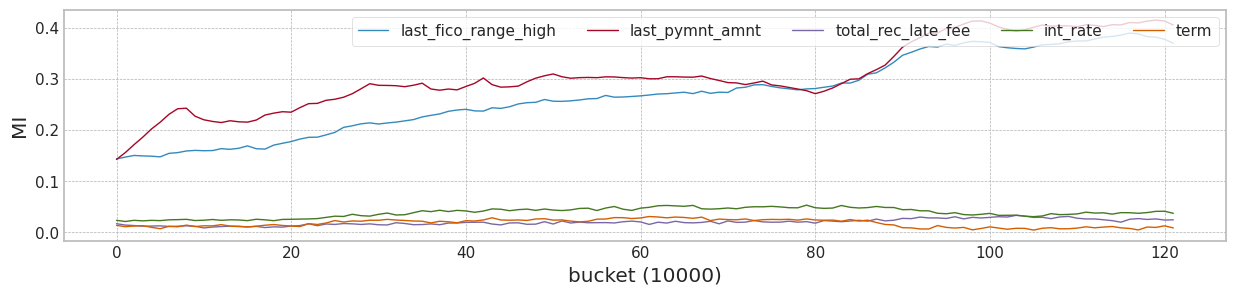

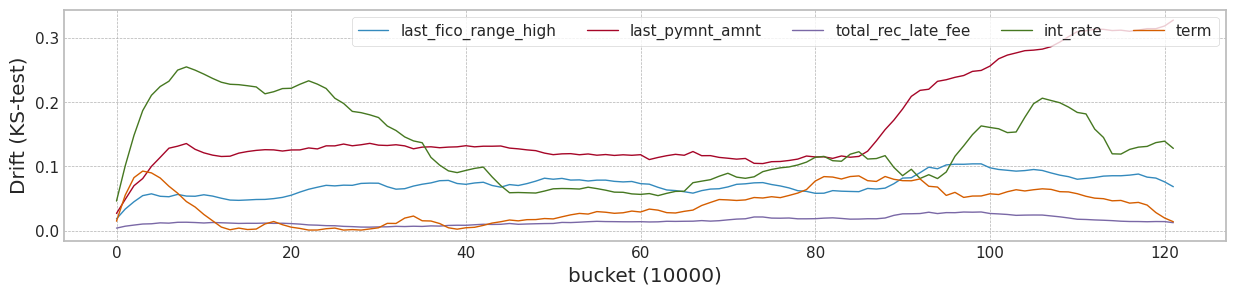

In [ ]:
train_size = 50000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [ ]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023107            0.000000  0.418593   
1                    0.857647         0.007334            0.000000  0.347201   
2                    0.722353         0.267822            0.000000  0.472008   
3                    0.863529         0.015264            0.000000  0.543400   
4                    0.945882         0.019326            0.000000  0.329224   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000189            0.083241  0.231638   
1279676              0.851765         0.283658            0.000000  0.231638   
1279677              0.898824         0.235068            0.000000  0.130971   
1279678              0.916471         0.682716            0.000000 -0.005136   
1279679              0.875294         0.264953            0.000000  1.303030   

         term    b  
0         0.0    0  
1         0.0    0  
2         0.0    0  
3         0.0    0  
4         0.0    0  
...       ...  ...  
1279675   0.0  255  
1279676   0.0  255  
1279677   0.0  255  
1279678   0.0  255  
1279679   1.0  255  

[1279680 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 611.78it/s]


Test f1 score: 0.9146633047863322
X_live.shape (1269680, 6)
Truncate 49680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 6])


100%|██████████| 122/122 [02:17<00:00,  1.12s/it]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
int_rate                0.135921
term                    0.038424
dtype: float64
Mean F1 for all data: 0.8887034030960396
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:22<00:00, 180.36it/s]


Test f1 score: 0.9301752617727755
X_live.shape (1269680, 6)
Truncate 49680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 6])


100%|██████████| 122/122 [02:14<00:00,  1.10s/it]


mean of drift:
last_fico_range_high    0.688812
last_pymnt_amnt         0.597681
total_rec_late_fee      0.983181
int_rate                0.297543
term                    0.722520
dtype: float64
Mean F1 for all data: 0.9572276905425564


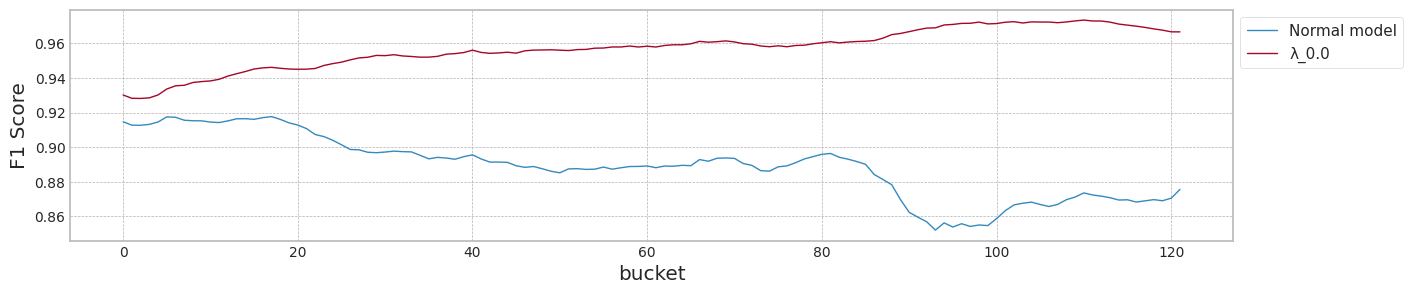

max_mean_lambda= 0.0


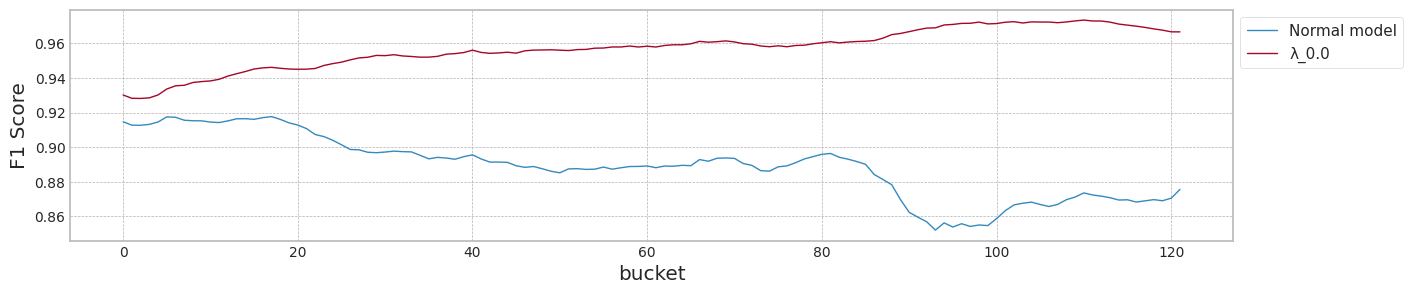

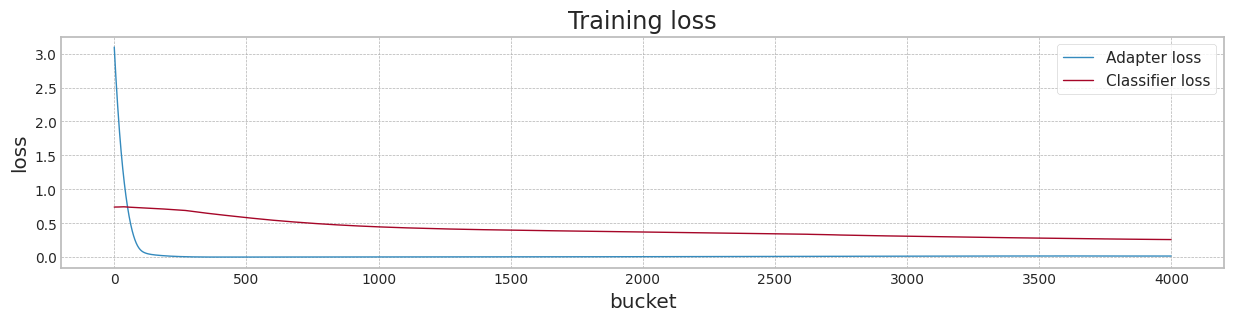

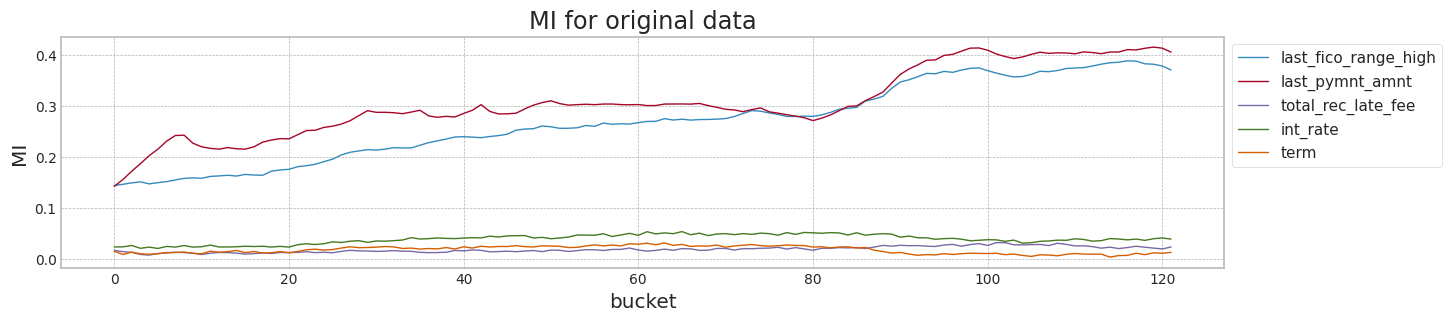

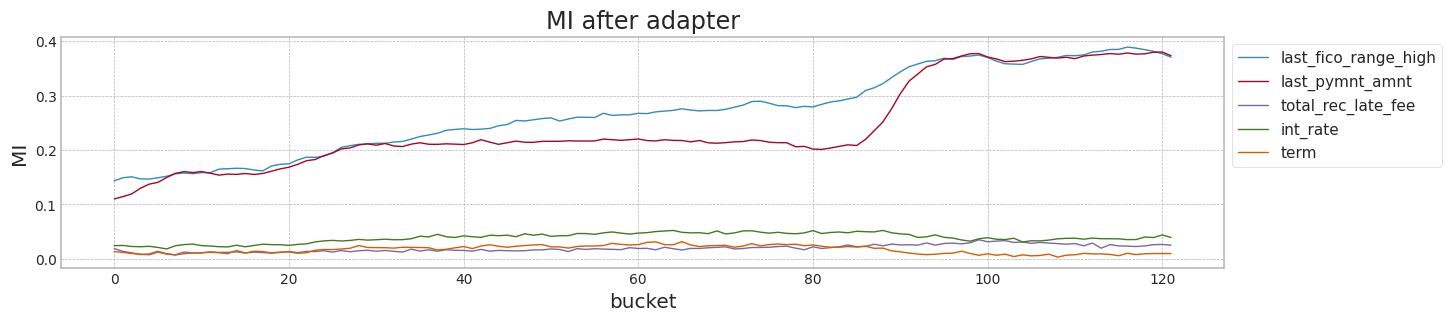

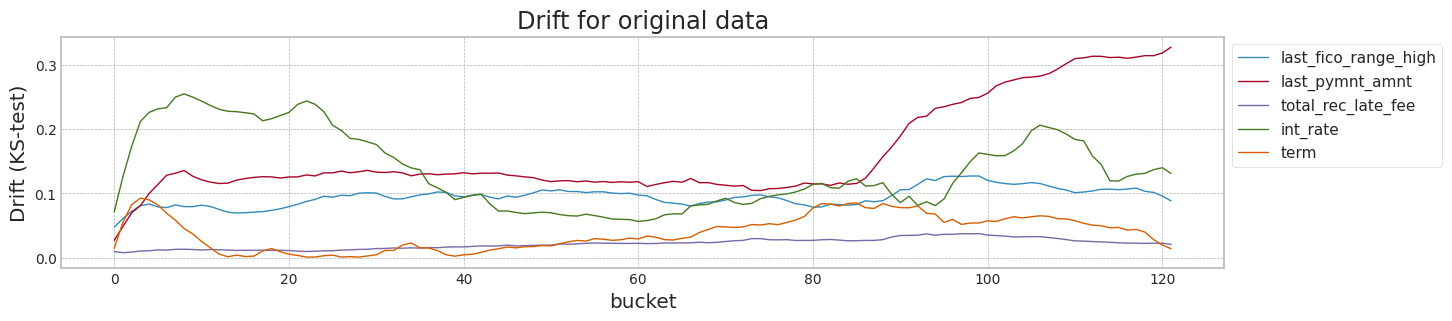

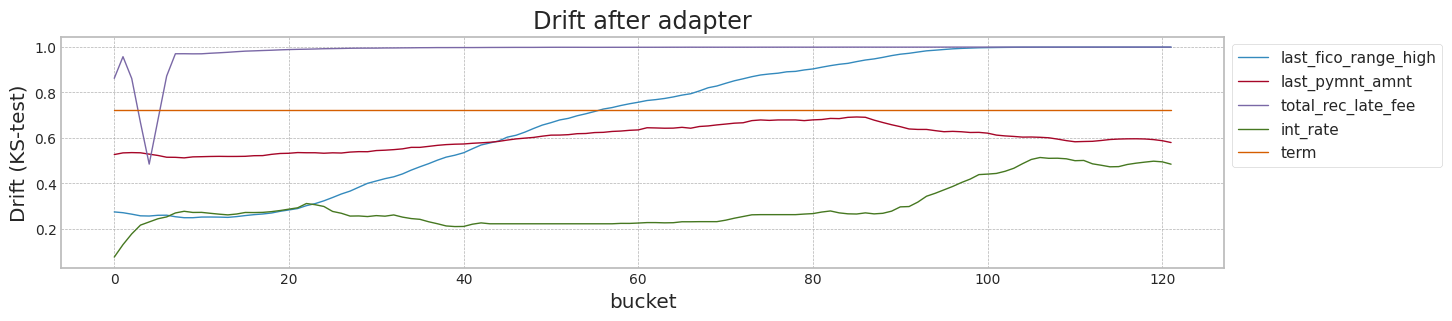

1    0.303088
Name: Test Sum(MI), dtype: float64
Test Sum(MI) max_lambda= 0.0


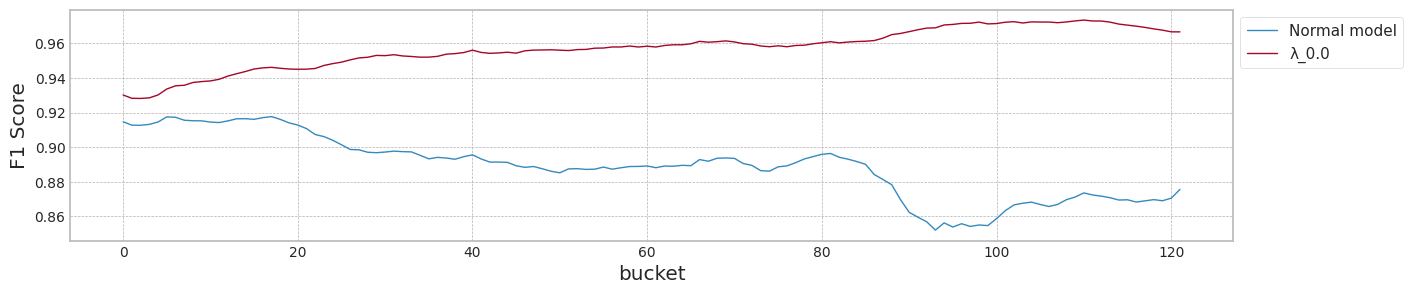

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0  Case #1, Normal model  0.914663  0.914663  0.888703  0.875463    0.201264   
1                    0.0  0.930175  0.930175  0.957228  0.966726    0.201757   

   Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR9.0)  \
0    0.027754    1.345802     0.38450    0.044974  ...    1.354331   
1    0.027822    1.345713     2.55682    0.301848  ...    1.469827   

   TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0      0.317269      0.053906      1.243285      0.338912      0.061303   
1      0.289811      0.048302      1.264346      0.303088      0.055284   

   Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      1.188848       0.00000      0.000000           NaN  
1      1.188741       2.46376      0.296848      1.385808  

[2 rows x 74 columns]

In [ ]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)
result_df

### Card data 실험

#### Dataset 준비

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [ ]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [ ]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [ ]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [ ]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [ ]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [ ]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


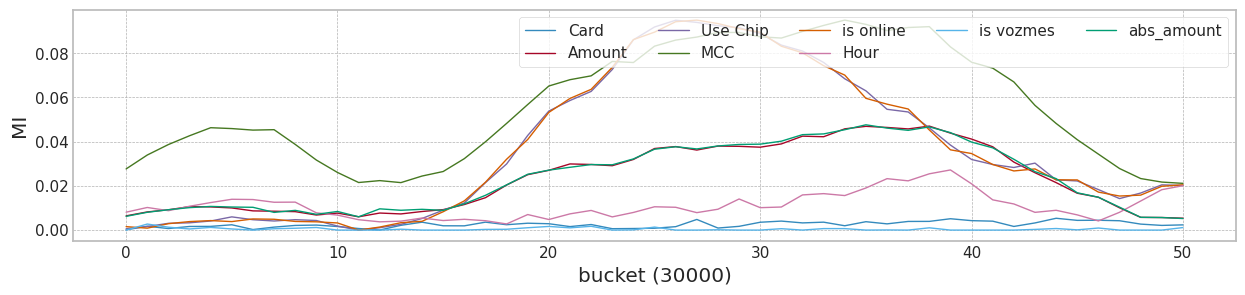

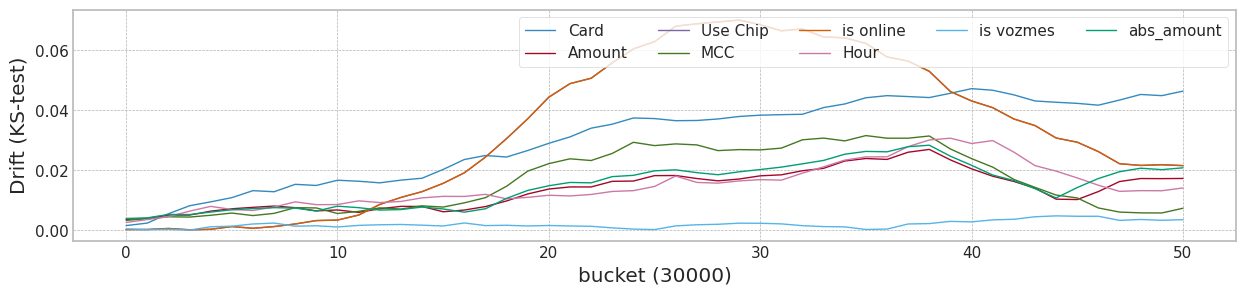

In [ ]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


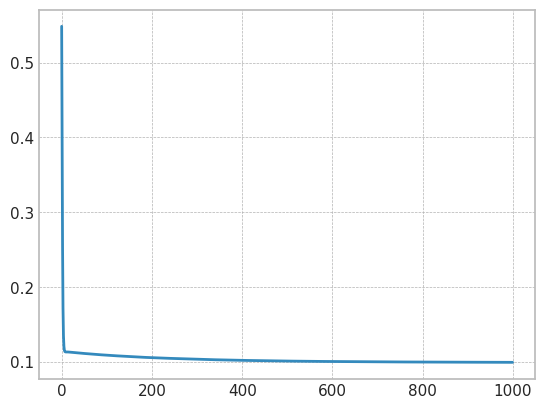

F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


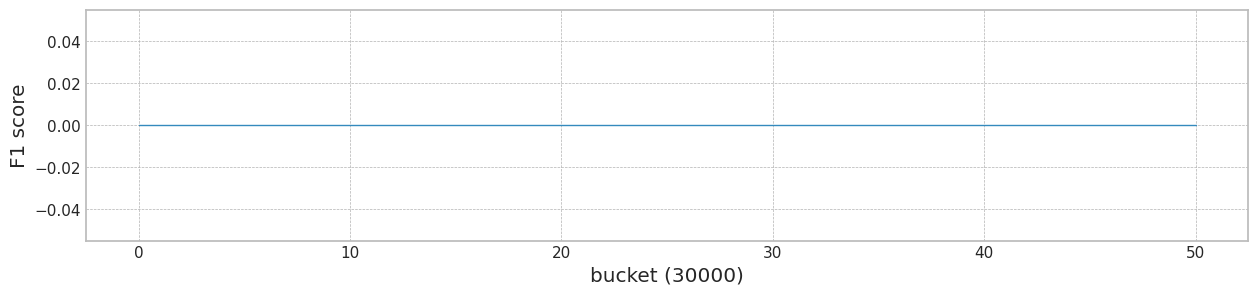

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [ ]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)